# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

# Try reweighting BCE loss with class weights

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch
import torch.nn as nn

import random

import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from skorch import NeuralNetRegressor,NeuralNetClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [3]:
set_seed(46)

Random seed set as 46


## Load data

In [4]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


locus_tag  gene                                 product type  strand  start  \
0     b0005  yaaX  DUF2502 domain-containing protein YaaX  CDS       1   5233   
1     b0007  yaaJ               putative transporter YaaJ  CDS      -1   6528   
2     b0008  talB                         transaldolase B  CDS       1   8237   
3     b0009   mog       molybdopterin adenylyltransferase  CDS       1   9305   
4     b0010  satP        acetate/succinate:H(+) symporter  CDS      -1   9927   

                                     upstream_region         0         1  \
0  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0.008229 -0.000685   
1  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0.008111 -0.003929   
2  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0.008629 -0.001270   
3  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0.002952  0.002053   
4  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0.006142  0.000884   

          2  ...        82        83        84        85        86        87  \
0 -0.005215  ... -0.006856  0.010676  0.008874  0.018497  0.000700 -0.013267   
1  0.003207  ... -0.000337 -0.010468  0.016122  0.010361 -0.003899 -0.022839   
2 -0.005664  ...  0.000394  0.007215 -0.000707 -0.012959 -0.002329  0.006391   
3 -0.002882  ... -0.009291 -0.000226  0.016013  0.002179  0.004891 -0.002365   
4  0.008166  ... -0.009214 -0.010588  0.001363  0.003979 -0.005208  0.003190   

         88        89        90        91  
0  0.015265  0.016886 -0.015319 -0.020727  
1 -0.003665 -0.001823 -0.023604 -0.012765  
2 -0.003650 -0.008537  0.002898 -0.000891  
3 -0.003490 -0.006066 -0.011982  0.011477  
4 -0.015137 -0.005784 -0.001302  0.010800  

[5 rows x 99 columns]

TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [5]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = [x.strip() for x in M.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [6]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

0  1  2  3  4  5  6  7  8  9  ...  82  83  84  85  86  87  88  89  \
locus_tag                                ...                                   
b0002      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0003      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0004      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0005      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0006      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
...       .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
b4688      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4693      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_1    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_2    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4705      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

           90  91  
locus_tag          
b0002       0   0  
b0003       0   0  
b0004       0   0  
b0005       0   0  
b0006       0   0  
...        ..  ..  
b4688       0   0  
b4693       0   0  
b4696_1     0   0  
b4696_2     0   0  
b4705       0   0  

[3923 rows x 92 columns]

In [7]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  82  83  84  85  86  87  88  89  90  91  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 99 columns]

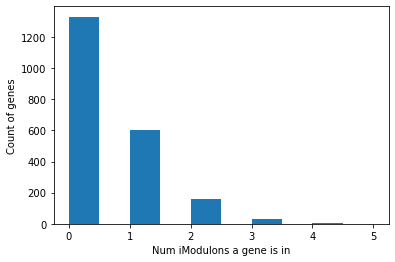

In [8]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Filter out uninformative iModulons (and genes?)
* Some iModulons have too few genes to learn from. Get rid of any less than 5. (after filtering out for genes in operons)
* Some genes aren't in any iModulons. Are those worth excluding too?

In [9]:
# make a list of imodulons above a certain threshold
thresh = 4
#mbc = dict([(Mb.iloc[i].name,sum(Mb.iloc[i])) for i in range(Mb.shape[0])])
XYim = XYb[imods]
mbc = dict([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])])
imods_filt = [x for x in mbc if mbc[x]>thresh]
print("num iMods that pass:",len(imods_filt))

num iMods that pass: 58


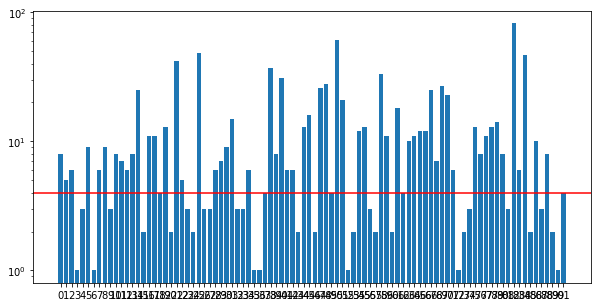

In [10]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods,[mbc[x] for x in imods])
plt.axhline(thresh,c='r')
plt.yscale("log")

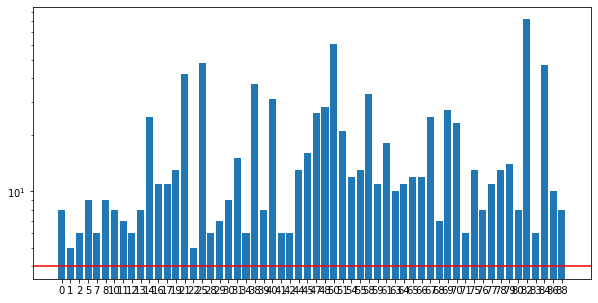

In [11]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods_filt,[mbc[x] for x in imods_filt])
plt.axhline(thresh,c='r')
plt.yscale("log")


In [12]:
# these iMods seem too small to meaningfully try to predict
# (some are single-gene iMods)
imods_exclude = [x for x in mbc if mbc[x]<=thresh]
print(f"num iMods filtered out b/c fewer than {thresh} genes: {len(imods_exclude)}")

num iMods filtered out b/c fewer than 4 genes: 34


In [13]:
# drop excluded iMods and keep binary labels
XY = XYb.drop(imods_exclude,axis=1)
XY

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  76  77  78  79  80  82  83  84  86  88  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 65 columns]

## stratified splitting

In [14]:
def count_imod_train_test_labels(imods,ytr,yte):
    '''
    Given a train and test set of y labels, count how many trues
    are in each imodulon for each split
    '''
    # loop through each train example and count True labels for each imodulon
    imc_train = torch.tensor([0 for x in range(ytr.shape[1])])
    for s in ytr:
        imc_train += s.long()

    # loop through each test example and count True labels for each imodulon
    imc_test = torch.tensor([0 for x in range(yte.shape[1])])
    for s in yte:
        imc_test += s.long()
    
    # print warning for missing examples
    for i,im in enumerate(imods):
        if imc_train[i] == 0:
            print(f"WARNING: iMod {im} train set missing True example.")
        if imc_test[i] == 0:
            print(f"WARNING: iMod {im} test set missing True example.")
            
    # make sure the len of these imod vectors is the same
    assert len(imc_train) == len(imc_test) == len(imods)

    # stack into a pandas df, melt it, plot it
    ts = np.array(torch.stack((torch.tensor([int(x) for x in imods]), imc_train, imc_test)).T)
    imc_df = pd.DataFrame(data=ts,columns=['imod','train_count','test_count'])
    imc_df_melt = imc_df.melt(id_vars=['imod'],value_vars=['train_count','test_count'],var_name='split',value_name='count')
    
    # plot stuff
    plt.figure(figsize=(20,5))
    sns.barplot(data=imc_df_melt, x='imod', y='count', hue='split')
    #plt.yscale('log')
    
    #return imc_df_melt

def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [15]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods_filt)
print("\nX:",X.shape)
print("y:",y.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])


In [16]:
from skmultilearn.model_selection import iterative_train_test_split


In [17]:
Xfull_train_strat, yfull_train_strat, Xtest_strat, ytest_strat = iterative_train_test_split(X, y, test_size = 0.2)
Xtrain_strat, ytrain_strat, Xval_strat, yval_strat = iterative_train_test_split(Xfull_train_strat, yfull_train_strat, test_size = 0.2)


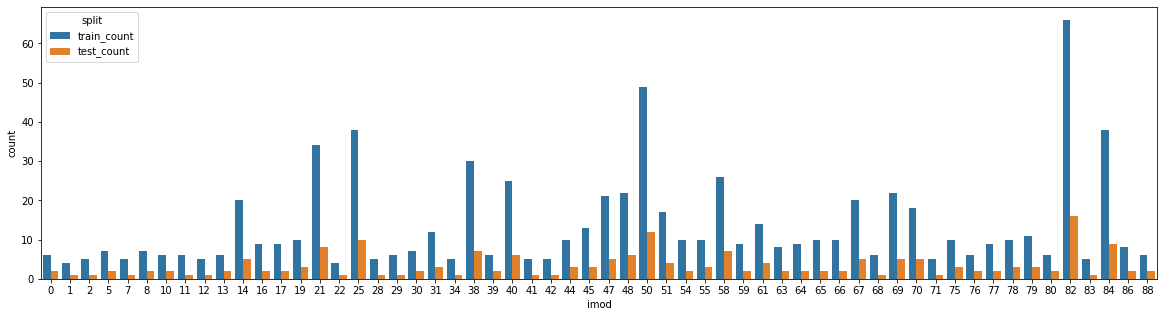

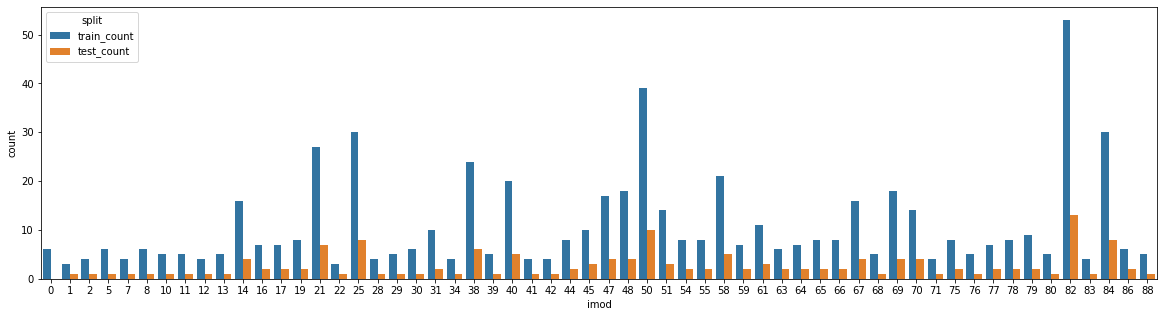

In [18]:
count_imod_train_test_labels(imods_filt,yfull_train_strat,ytest_strat)
count_imod_train_test_labels(imods_filt,ytrain_strat,yval_strat)

## pick some params

In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [20]:
from skorch.dataset import ValidSplit

In [21]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_val = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [22]:
net_strat_val.fit(Xtrain_strat, ytrain_strat)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3336       0.5777        0.0675  3.1876
      2        0.0674       0.5777        0.0516  0.1647
      3        0.0494       0.5777        0.0452  0.1434
      4        0.0456       0.5777        0.0435  0.1375
      5        0.0441       0.5777        0.0430  0.1375
      6        0.0438       0.5777        0.0426  0.1375
      7        0.0438       0.5777        0.0426  0.1369
      8        0.0437       0.5777        0.0426  0.1377
      9        0.0438       0.5777        0.0427  0.1379
     10        0.0436       0.5777        0.0426  0.1381
     11        0.0436       0.5777        0.0427  0.1375
     12        0.0437       0.5777        0.0425  0.1378
     13        0.0436       0.5777        0.0427  0.1371
     14        0.0435       0.5777        0.0425  0.1377
     15        0.0435       0.5777        0.0425  0.1380
     16        0.0434       0.5

    127        0.0014       0.5132        0.1295  0.1386
    128        0.0014       0.5103        0.1266  0.1385
    129        0.0013       0.5220        0.1325  0.1386
    130        0.0016       0.5249        0.1346  0.1385
    131        0.0016       0.5396        0.1368  0.1383
    132        0.0017       0.5161        0.1346  0.1391
    133        0.0018       0.5103        0.1307  0.1385
    134        0.0012       0.5455        0.1375  0.1384
    135        0.0013       0.5044        0.1302  0.1393
    136        0.0010       0.5337        0.1406  0.1387
    137        0.0012       0.5249        0.1410  0.1385
    138        0.0011       0.5103        0.1394  0.1383
    139        0.0009       0.5425        0.1410  0.1388
Stopping since valid_loss has not improved in the last 100 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

# Viz model results

In [23]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color=alt.Color('score:Q',scale=alt.Scale(domain=(0.0,1.0))),
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def view_cls_report(sk_model,Xs,ys,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    
    

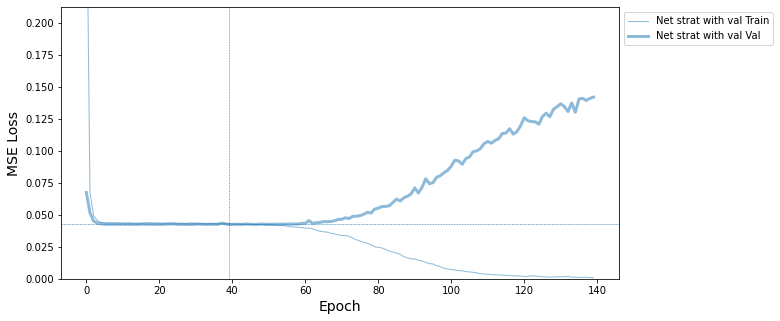

In [24]:
nets = [
    (net_strat_val,'Net strat with val'),
]

sk_loss_plot(nets)

In [25]:
#plot_confusion_multi(nets, Xval_strat,yval_strat,imods_filt)

In [26]:
cls_full_train_df = view_cls_report(net_strat_val,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_val,Xval_strat,yval_strat,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

## BCEwithlogitsloss reweighting?

In [27]:
def get_class_counts(ys):
    y_sum = torch.tensor(np.zeros(ys.shape[1]))
    for ex in ys:
        y_sum += ex

    return y_sum

# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/11?u=crypdick
def get_pos_weights(ys):
    class_counts = get_class_counts(ys)
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(ys)-pos_count for pos_count in class_counts]  # <-- HERE 
    
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        print(f"{cdx}| pos:{pos_count}  neg:{neg_count}")
        print("val:", neg_count / (pos_count + 1e-5))
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)
        

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [28]:
bce_pos_weights = get_pos_weights(y)

0| pos:8.0  neg:2121.0
val: tensor(265.1247, dtype=torch.float64)
1| pos:5.0  neg:2124.0
val: tensor(424.7992, dtype=torch.float64)
2| pos:6.0  neg:2123.0
val: tensor(353.8327, dtype=torch.float64)
3| pos:9.0  neg:2120.0
val: tensor(235.5553, dtype=torch.float64)
4| pos:6.0  neg:2123.0
val: tensor(353.8327, dtype=torch.float64)
5| pos:9.0  neg:2120.0
val: tensor(235.5553, dtype=torch.float64)
6| pos:8.0  neg:2121.0
val: tensor(265.1247, dtype=torch.float64)
7| pos:7.0  neg:2122.0
val: tensor(303.1424, dtype=torch.float64)
8| pos:6.0  neg:2123.0
val: tensor(353.8327, dtype=torch.float64)
9| pos:8.0  neg:2121.0
val: tensor(265.1247, dtype=torch.float64)
10| pos:25.0  neg:2104.0
val: tensor(84.1600, dtype=torch.float64)
11| pos:11.0  neg:2118.0
val: tensor(192.5453, dtype=torch.float64)
12| pos:11.0  neg:2118.0
val: tensor(192.5453, dtype=torch.float64)
13| pos:13.0  neg:2116.0
val: tensor(162.7691, dtype=torch.float64)
14| pos:42.0  neg:2087.0
val: tensor(49.6905, dtype=torch.float64)
15

In [29]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [30]:
net_strat_bcew.fit(Xtrain_strat, ytrain_strat)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3881       0.0000        1.3561  0.2635
      2        1.3839       0.0000        1.3560  0.1561
      3        1.3839       0.0000        1.3561  0.1413
      4        1.3836       0.0000        1.3560  0.1407
      5        1.3833       0.0000        1.3560  0.1399
      6        1.3829       0.0000        1.3559  0.1400
      7        1.3795       0.0000        1.3555  0.1421
      8        1.3715       0.0000        1.3558  0.1418
      9        1.3631       0.0000        1.3567  0.1410
     10        1.3470       0.0000        1.3702  0.1416
     11        1.2929       0.0000        1.3956  0.1478
     12        1.2166       0.0000        1.5014  0.1460
     13        1.1569       0.0000        1.5421  0.1407
     14        1.0963       0.0000        1.6424  0.1430
     15        1.0673       0.0000        1.5730  0.1432
     16        0.9958       0.0

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

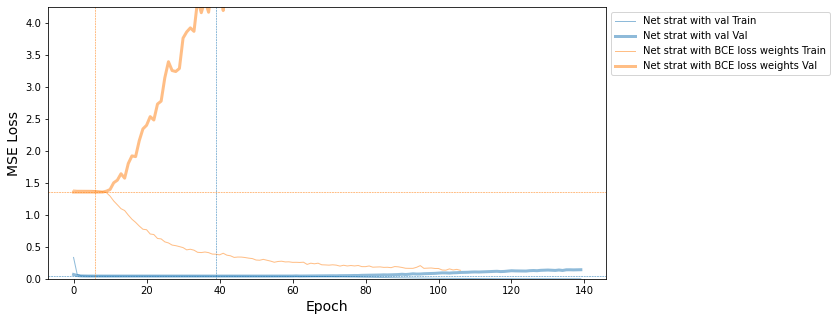

In [31]:
nets = [
    (net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights')
]

sk_loss_plot(nets,yscaler=100)

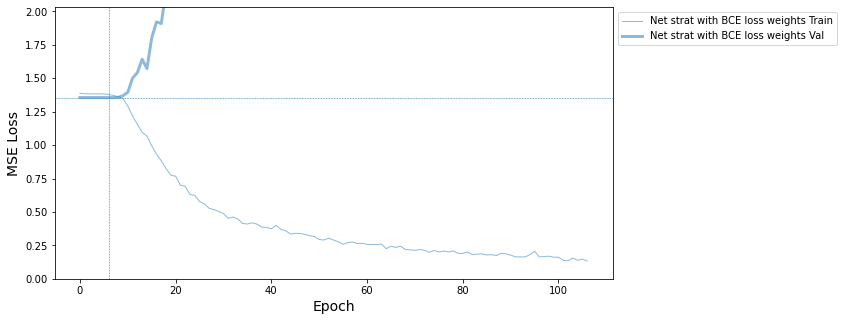

In [32]:

sk_loss_plot([(net_strat_bcew,'Net strat with BCE loss weights')],yscaler=1.5)

In [33]:
cls_full_train_df = view_cls_report(net_strat_bcew,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew,Xval_strat,yval_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

Running Net strat with BCE loss weights


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


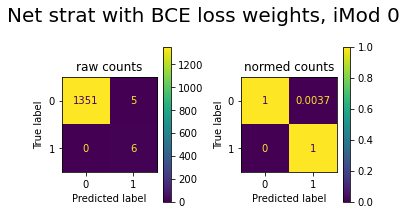

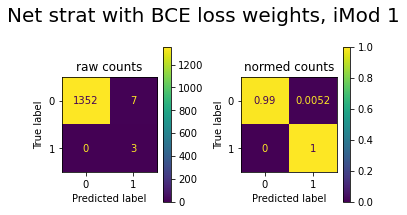

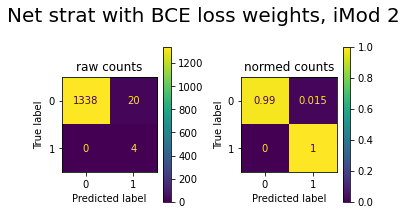

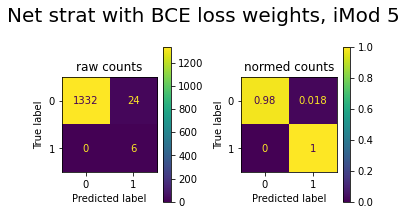

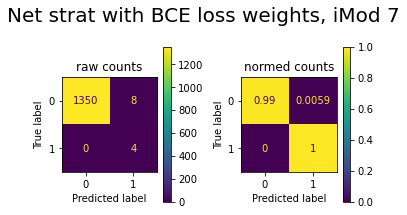

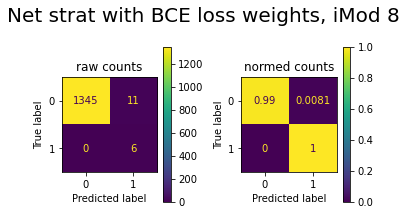

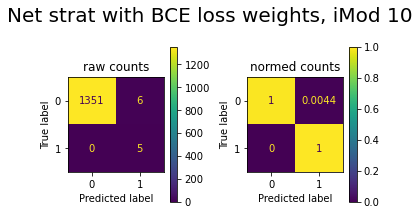

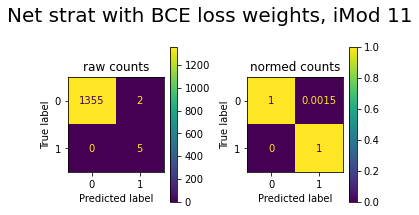

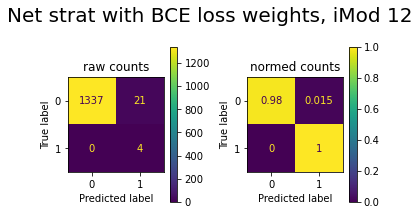

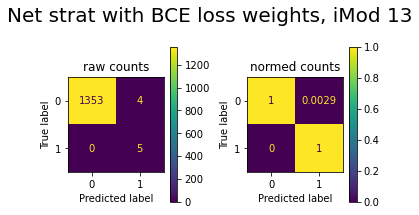

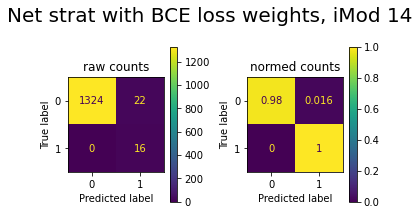

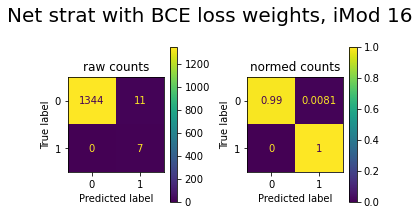

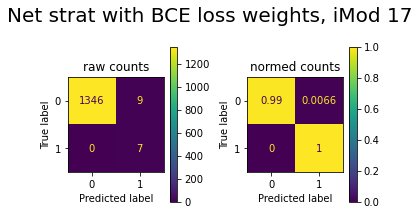

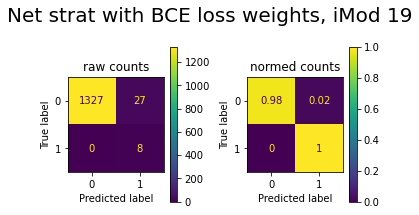

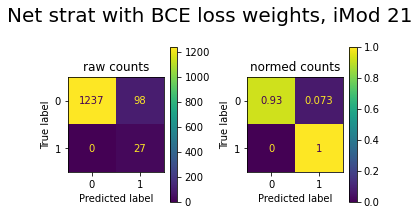

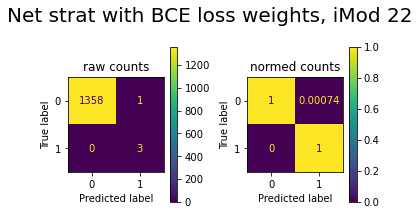

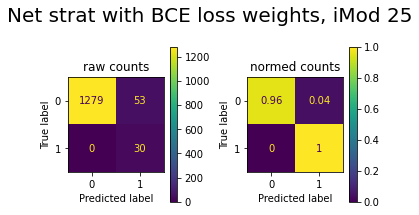

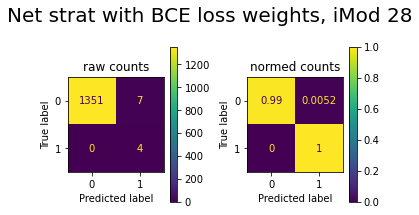

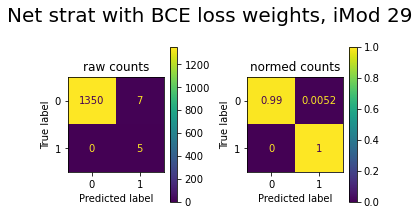

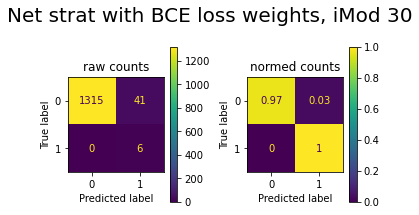

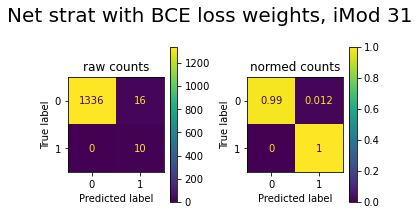

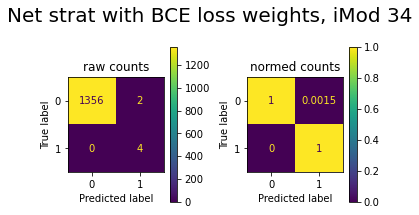

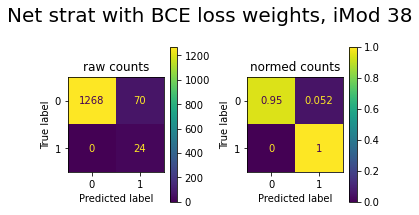

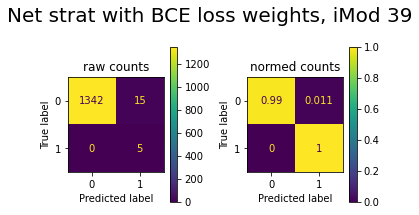

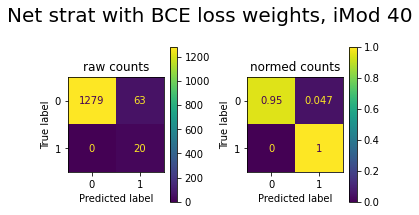

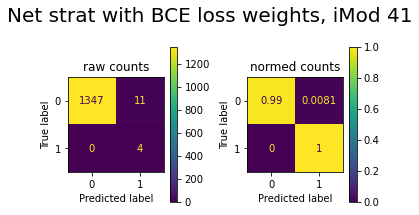

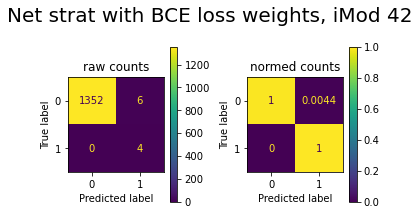

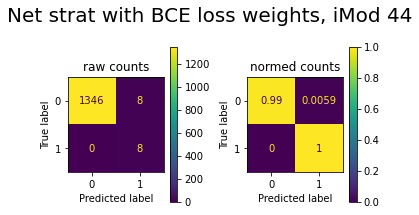

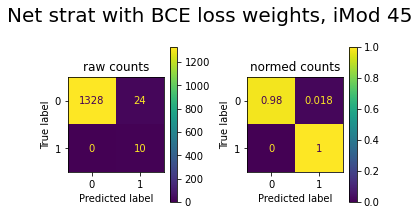

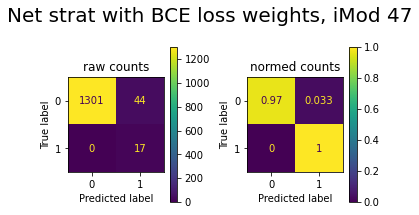

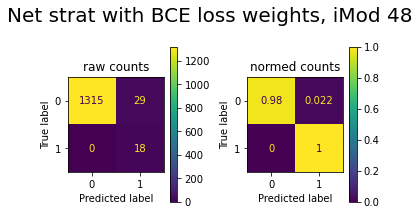

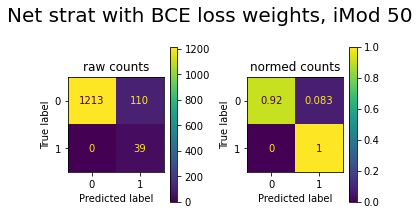

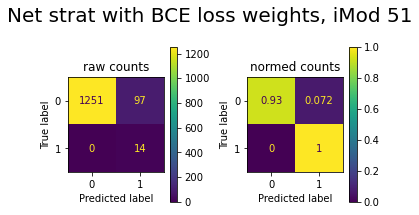

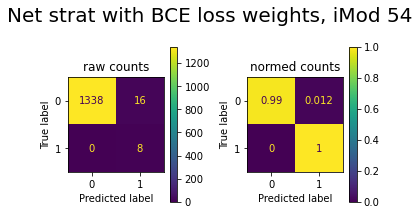

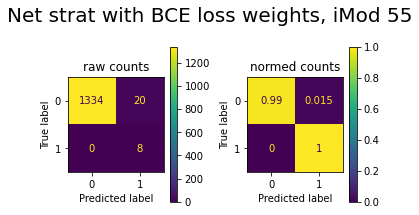

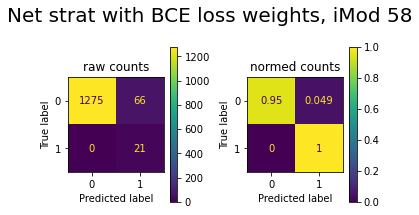

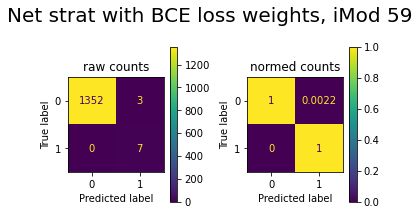

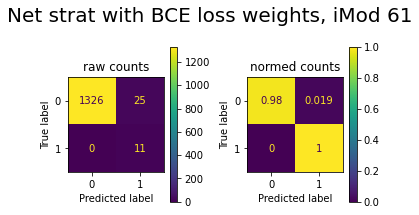

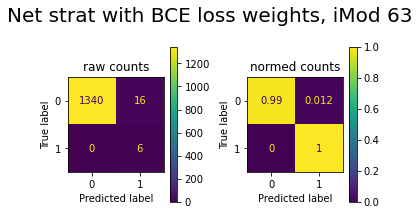

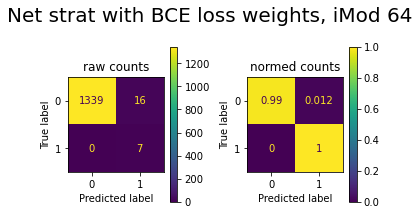

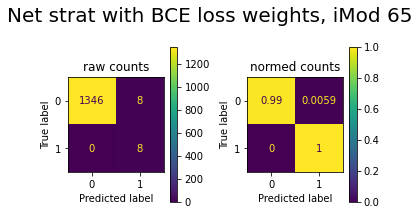

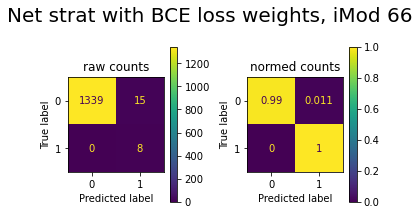

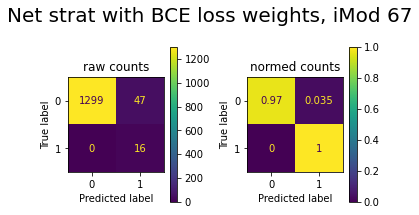

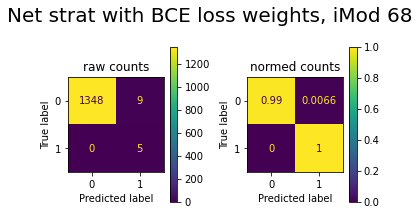

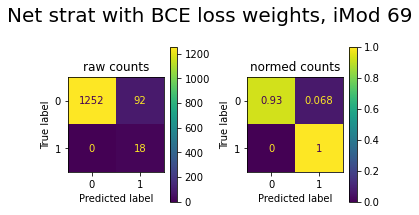

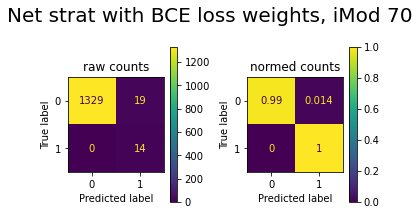

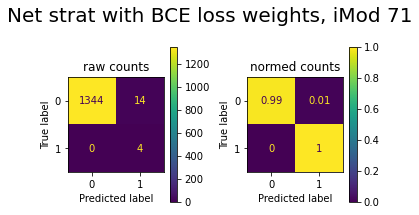

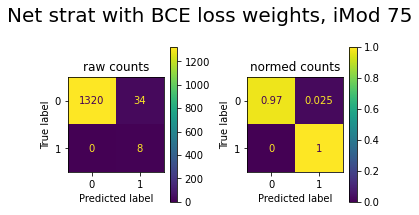

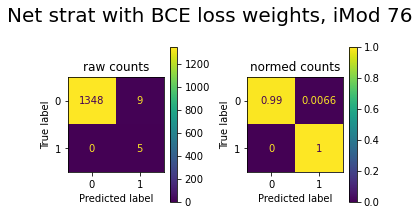

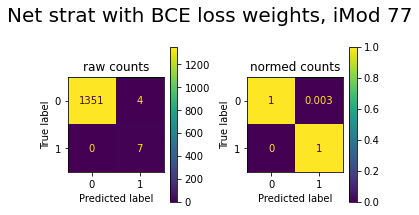

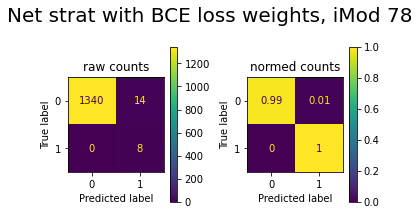

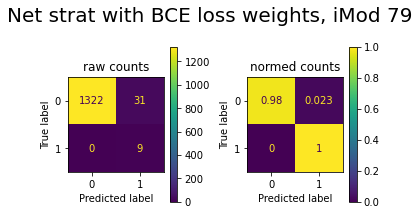

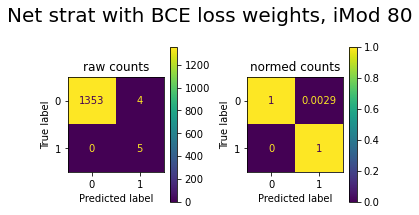

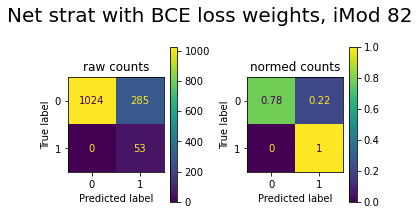

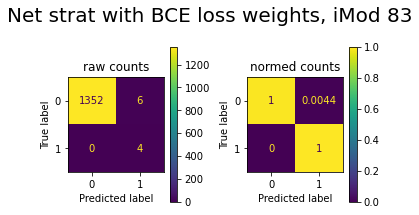

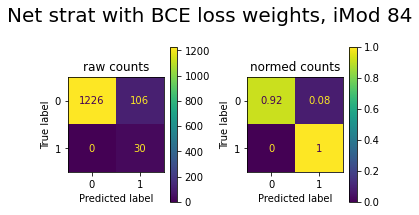

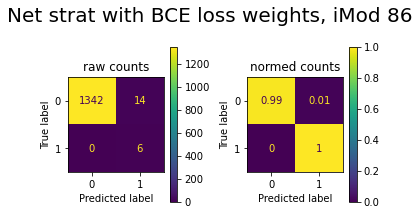

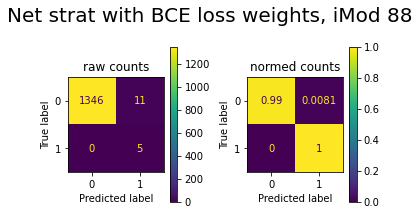

In [34]:
plot_confusion_multi([(net_strat_bcew,'Net strat with BCE loss weights')], Xtrain_strat,ytrain_strat,imods_filt)

Running Net strat with BCE loss weights


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


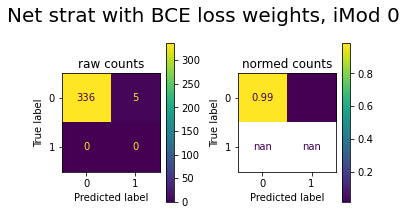

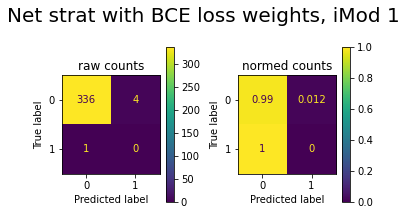

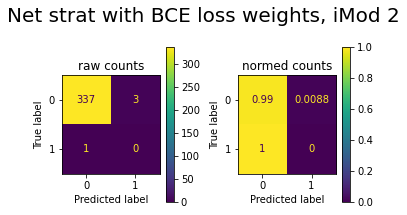

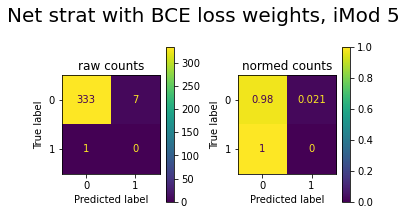

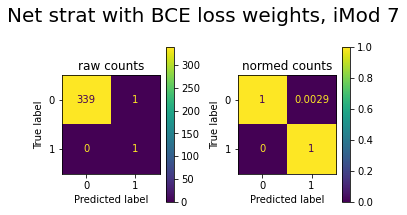

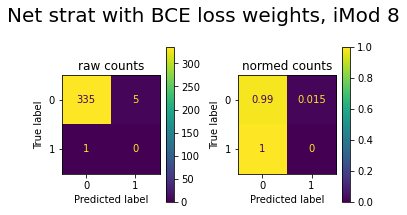

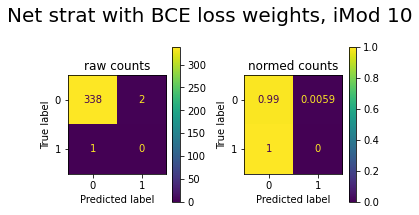

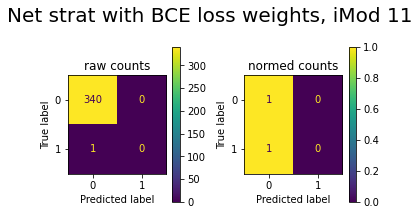

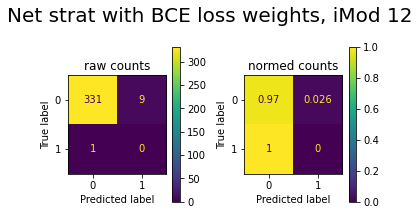

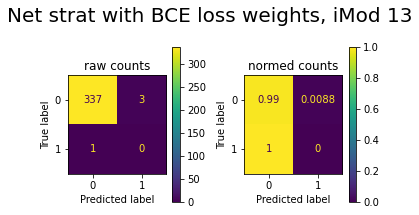

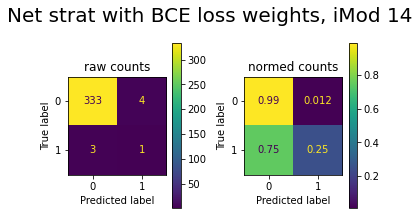

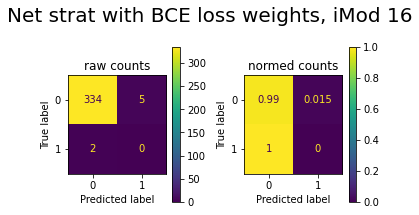

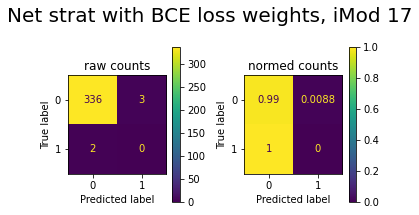

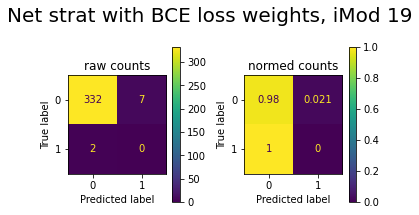

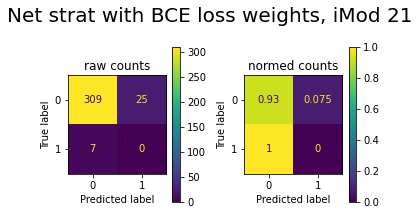

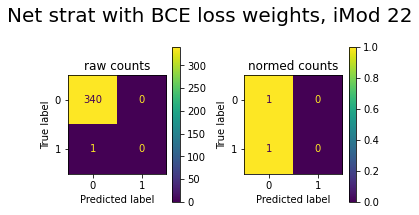

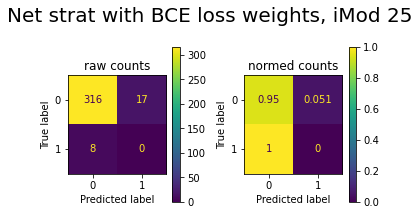

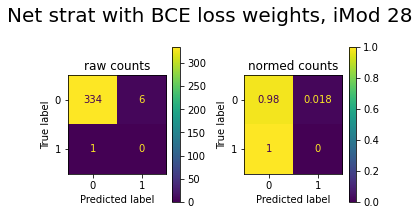

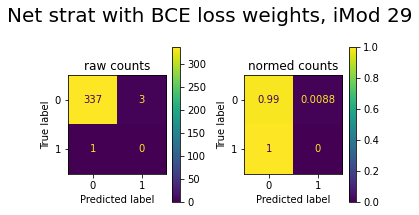

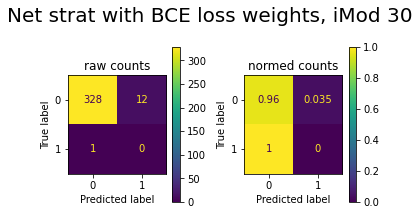

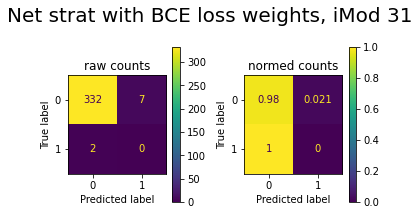

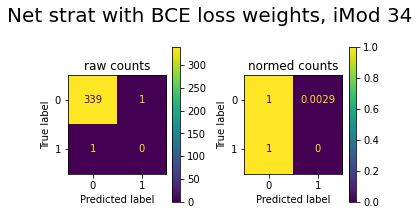

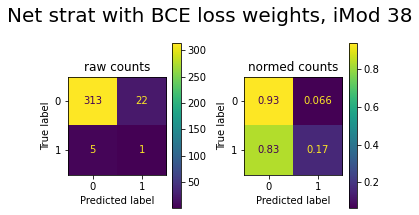

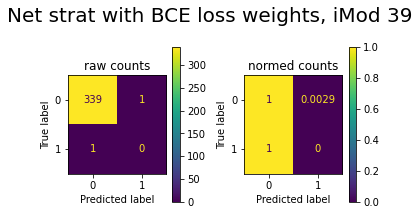

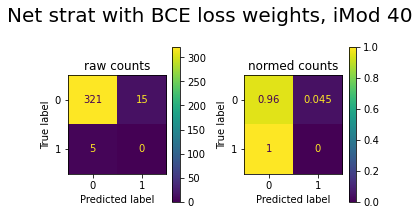

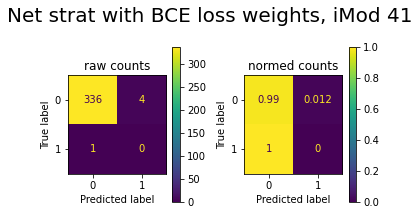

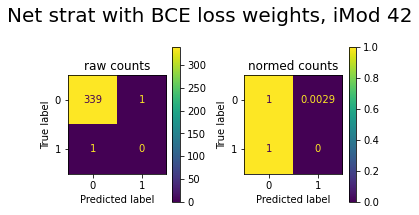

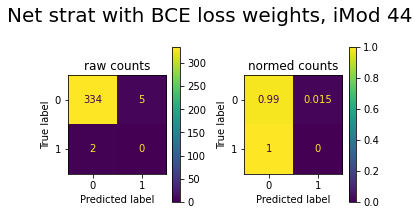

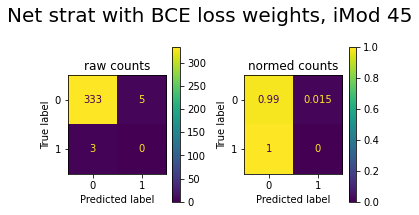

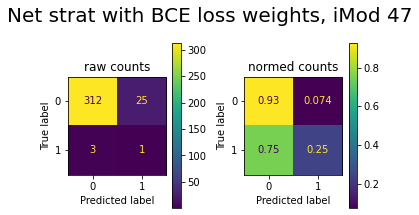

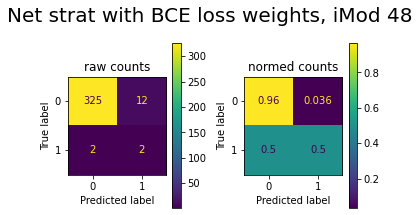

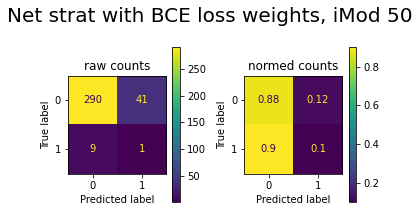

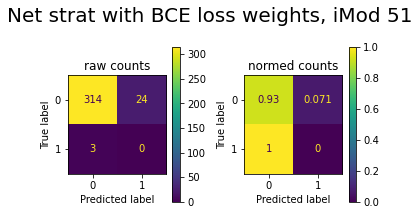

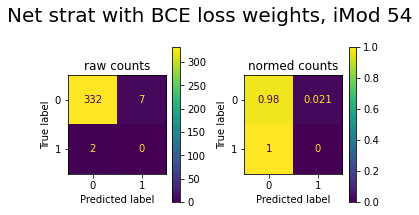

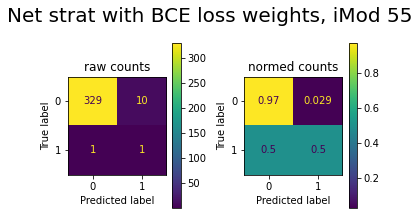

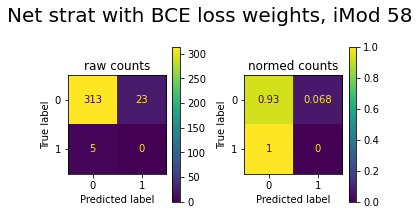

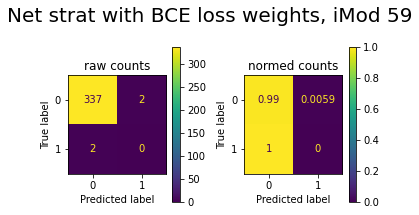

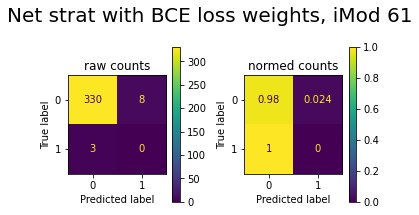

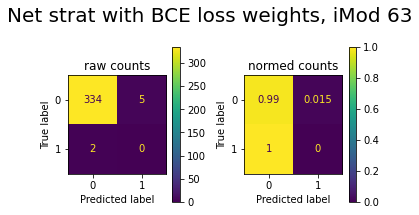

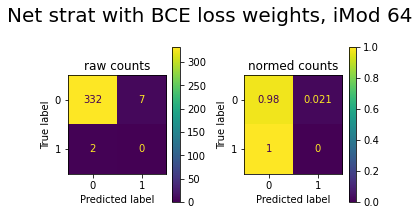

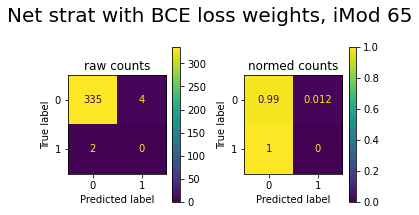

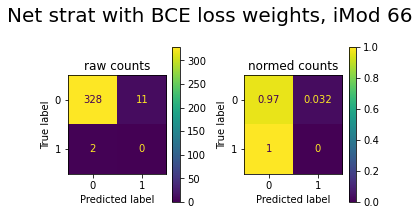

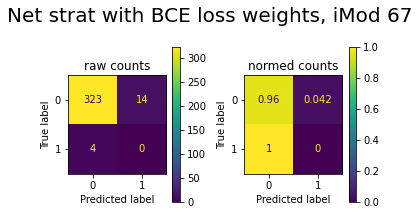

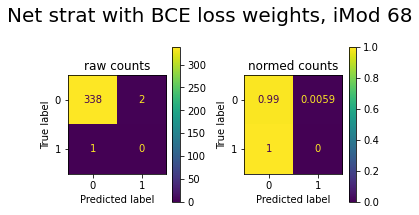

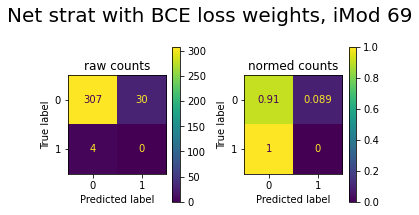

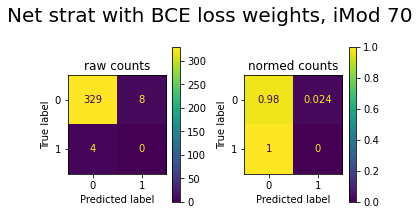

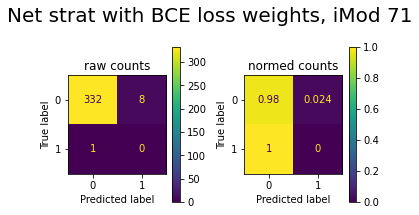

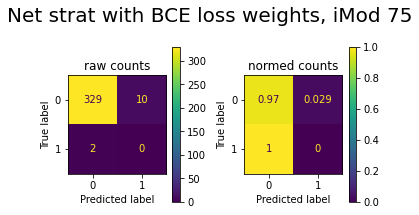

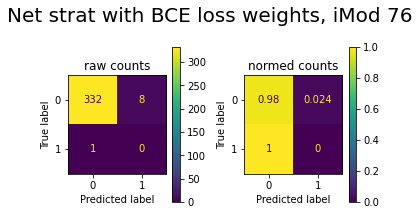

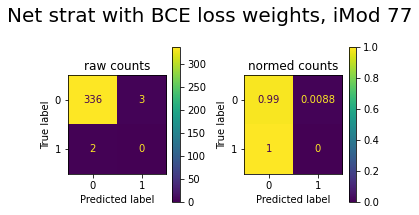

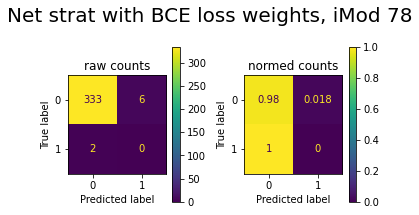

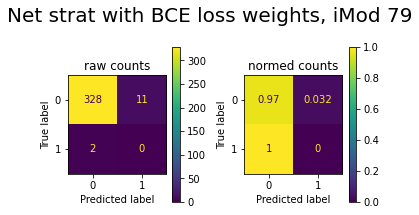

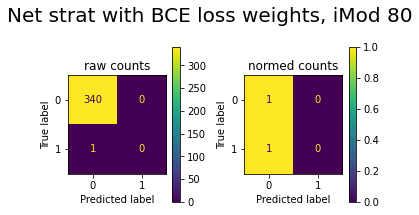

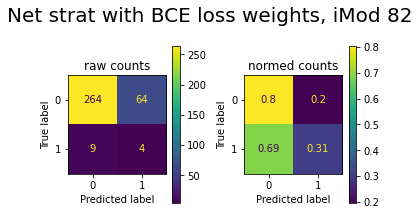

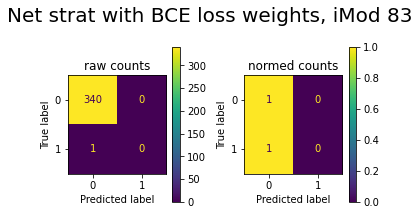

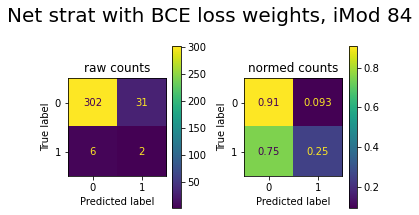

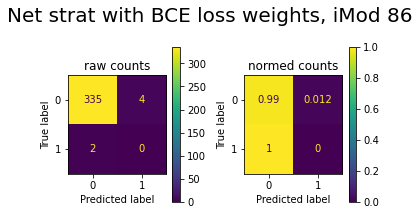

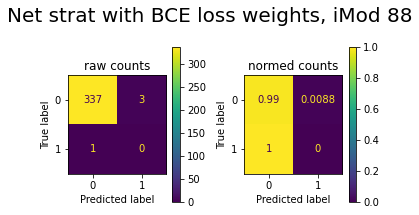

In [35]:
plot_confusion_multi([(net_strat_bcew,'Net strat with BCE loss weights')], Xval_strat,yval_strat,imods_filt)

## fiddle with params with bce weights

In [36]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew_tink5 = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=64,
    module__num_filters2=8,
    module__kernel_size1=8,
    module__kernel_size2=3,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 50,
    module__fc_node_num2 = 50,
    module__dropout1 = 0.2,
    module__dropout2 = 0.4,
    max_epochs=2000,
    lr=0.0001,
    batch_size=256,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=1000),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [37]:
net_strat_bcew_tink5.fit(Xtrain_strat,ytrain_strat)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3846       0.0000        1.3554  0.1788
      2        1.3844       0.0000        1.3554  0.1199
      3        1.3848       0.0000        1.3554  0.1027
      4        1.3844       0.0000        1.3554  0.0898
      5        1.3837       0.0000        1.3553  0.0883
      6        1.3836       0.0000        1.3553  0.0880
      7        1.3836       0.0000        1.3554  0.0879
      8        1.3835       0.0000        1.3554  0.0876
      9        1.3841       0.0000        1.3555  0.0877
     10        1.3844       0.0000        1.3555  0.0876
     11        1.3837       0.0000        1.3555  0.0880
     12        1.3830       0.0000        1.3555  0.0880
     13        1.3829       0.0000        1.3555  0.0877
     14        1.3830       0.0000        1.3556  0.0892
     15        1.3828       0.0000        1.3556  0.0879
     16        1.3826       0.0

    129        1.0254       0.0000        1.5327  0.0901
    130        1.0328       0.0000        1.5337  0.0892
    131        1.0176       0.0000        1.5313  0.0889
    132        1.0262       0.0000        1.5209  0.0888
    133        1.0258       0.0000        1.5276  0.0891
    134        1.0223       0.0000        1.5327  0.0890
    135        1.0191       0.0000        1.5537  0.0890
    136        1.0100       0.0000        1.5521  0.0888
    137        0.9803       0.0000        1.5861  0.0890
    138        0.9910       0.0000        1.5824  0.0890
    139        0.9940       0.0000        1.5866  0.0895
    140        0.9776       0.0000        1.6033  0.0893
    141        0.9632       0.0000        1.6157  0.0890
    142        0.9541       0.0000        1.6203  0.0890
    143        0.9364       0.0000        1.6166  0.0891
    144        0.9614       0.0000        1.6459  0.0891
    145        0.9276       0.0000        1.6728  0.0899
    146        0.9333       0.0

    264        0.5785       0.0117        2.7620  0.0899
    265        0.5643       0.0088        2.7836  0.0891
    266        0.5671       0.0029        2.8764  0.0895
    267        0.5668       0.0029        2.9162  0.0908
    268        0.5475       0.0029        2.9234  0.0895
    269        0.5619       0.0117        2.9082  0.0888
    270        0.5652       0.0059        2.8878  0.0886
    271        0.5465       0.0088        2.8884  0.0887
    272        0.5433       0.0088        2.9148  0.0888
    273        0.5259       0.0147        2.9678  0.0887
    274        0.5677       0.0176        2.9593  0.0890
    275        0.5370       0.0117        2.9587  0.0894
    276        0.5458       0.0088        2.9791  0.0897
    277        0.5409       0.0147        2.9491  0.0896
    278        0.5296       0.0147        3.0000  0.0908
    279        0.5374       0.0117        2.9982  0.0892
    280        0.5418       0.0029        2.9004  0.0890
    281        0.5299       0.0

    402        0.3909       0.0293        4.0215  0.0902
    403        0.3767       0.0411        4.0490  0.0900
    404        0.3897       0.0411        4.0599  0.0901
    405        0.3699       0.0381        4.0050  0.0908
    406        0.4089       0.0440        3.9907  0.0912
    407        0.3821       0.0440        4.0284  0.0911
    408        0.3704       0.0411        4.1004  0.0911
    409        0.3864       0.0323        4.0897  0.0915
    410        0.3829       0.0323        4.0261  0.0909
    411        0.3933       0.0293        4.0008  0.0914
    412        0.3806       0.0264        4.0556  0.0912
    413        0.3858       0.0293        4.0685  0.0926
    414        0.3747       0.0411        4.1202  0.0923
    415        0.3911       0.0352        4.1318  0.0923
    416        0.3794       0.0381        4.0961  0.0919
    417        0.3721       0.0352        4.0865  0.0905
    418        0.3696       0.0381        4.0915  0.0914
    419        0.3706       0.0

    542        0.2793       0.0557        4.9504  0.0900
    543        0.2960       0.0528        4.9768  0.0904
    544        0.2936       0.0469        5.0383  0.0905
    545        0.2932       0.0587        5.0536  0.0899
    546        0.2910       0.0528        5.0141  0.0908
    547        0.2712       0.0587        5.0854  0.0909
    548        0.2824       0.0674        5.1721  0.0901
    549        0.3013       0.0557        5.1167  0.0901
    550        0.2855       0.0528        4.9967  0.0916
    551        0.2815       0.0499        4.9714  0.0900
    552        0.2944       0.0587        5.0117  0.0898
    553        0.2773       0.0762        5.0933  0.0895
    554        0.2833       0.0762        5.1340  0.0898
    555        0.2899       0.0674        5.1020  0.0901
    556        0.2792       0.0528        5.1175  0.0896
    557        0.2821       0.0528        5.1320  0.0893
    558        0.2770       0.0616        5.1343  0.0894
    559        0.2896       0.0

    682        0.2332       0.0880        5.9928  0.0909
    683        0.2234       0.0968        6.0202  0.0892
    684        0.2268       0.0880        5.9754  0.0909
    685        0.2269       0.0792        5.9119  0.0897
    686        0.2465       0.0762        5.8683  0.0897
    687        0.2195       0.0880        5.8304  0.0892
    688        0.2271       0.0938        5.9202  0.0900
    689        0.2363       0.0938        5.9196  0.0902
    690        0.2261       0.0762        5.8319  0.0909
    691        0.2311       0.0704        5.7977  0.0902
    692        0.2246       0.0792        5.7746  0.0904
    693        0.2250       0.0880        5.8693  0.0898
    694        0.2202       0.0938        6.0045  0.0907
    695        0.2174       0.0968        6.0411  0.0911
    696        0.2264       0.0792        6.0030  0.0906
    697        0.2308       0.0645        5.9450  0.0934
    698        0.2329       0.0762        5.9146  0.0913
    699        0.2106       0.0

    823        0.1897       0.1173        6.7034  0.0896
    824        0.1791       0.1056        6.7566  0.0896
    825        0.1783       0.1202        6.8173  0.0901
    826        0.1739       0.1173        6.8478  0.0898
    827        0.1892       0.1261        6.8292  0.0901
    828        0.1924       0.1232        6.7823  0.0897
    829        0.1873       0.0938        6.7036  0.0900
    830        0.1916       0.1056        6.7135  0.1595
    831        0.1941       0.1085        6.7246  0.0902
    832        0.1830       0.1202        6.7135  0.0897
    833        0.1774       0.1232        6.7735  0.0903
    834        0.1877       0.1261        6.8256  0.0903
    835        0.1830       0.1261        6.8724  0.0897
    836        0.1806       0.1290        6.9390  0.0911
    837        0.1895       0.1349        6.9014  0.0904
    838        0.1840       0.1202        6.8006  0.0897
    839        0.1834       0.1202        6.7896  0.0891
    840        0.2002       0.1

    964        0.1661       0.1408        7.4025  0.0903
    965        0.1570       0.1261        7.3522  0.0908
    966        0.1641       0.1202        7.3512  0.0900
    967        0.1658       0.1320        7.4098  0.0896
    968        0.1604       0.1408        7.4852  0.0904
    969        0.1613       0.1496        7.5363  0.0917
    970        0.1538       0.1496        7.5578  0.0923
    971        0.1570       0.1496        7.6271  0.0920
    972        0.1539       0.1466        7.6282  0.0925
    973        0.1428       0.1496        7.6782  0.0924
    974        0.1624       0.1378        7.6388  0.0931
    975        0.1591       0.1349        7.5267  0.0930
    976        0.1550       0.1290        7.4372  0.0918
    977        0.1553       0.1408        7.4729  0.0934
    978        0.1570       0.1554        7.4864  0.0933
    979        0.1606       0.1437        7.4836  0.0920
    980        0.1499       0.1320        7.5175  0.0915
    981        0.1491       0.1

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 8, kernel_size=(1, 3), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=760, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=50, bias=True)
      (11): ReLU()
      (12): Linear(in_features=50, out_features=58, bias=True)
    )
  ),
)

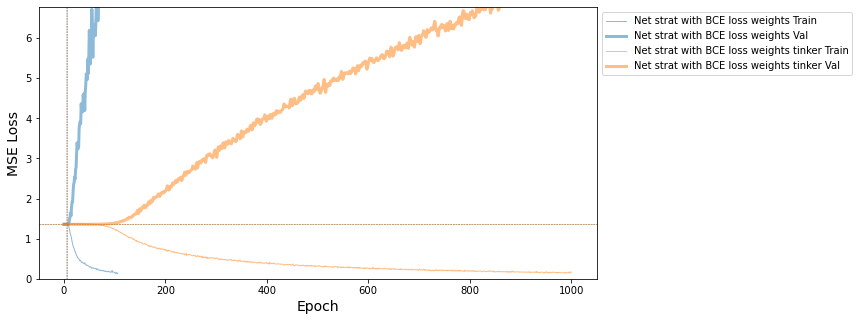

In [38]:
nets = [
    #(net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights'),
#     (net_strat_bcew_tink,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink2,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink3,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink4,'Net strat with BCE loss weights tinker'),
    (net_strat_bcew_tink5,'Net strat with BCE loss weights tinker'),
]


sk_loss_plot(nets,yscaler=5)

In [39]:
cls_full_train_df = view_cls_report(net_strat_bcew_tink5,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew_tink5,Xval_strat,yval_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew_tink5,Xtest_strat,ytest_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

Running bce weight tinkering


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


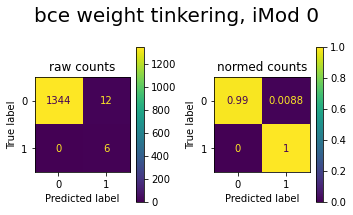

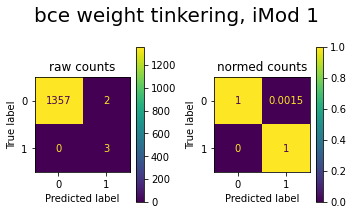

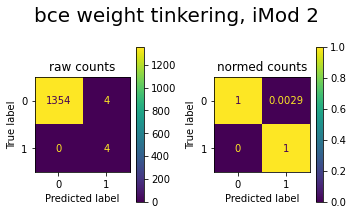

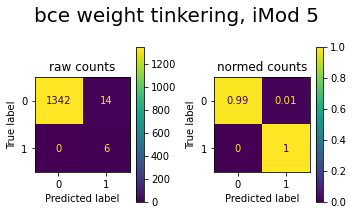

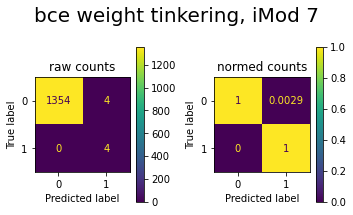

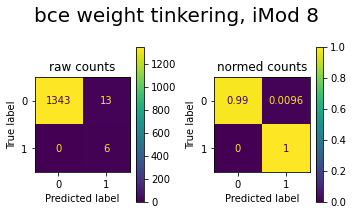

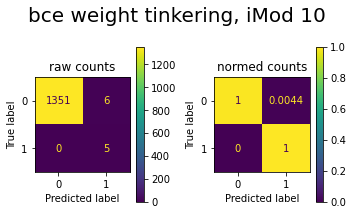

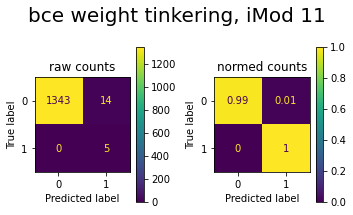

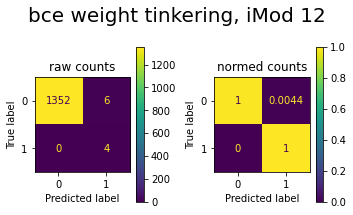

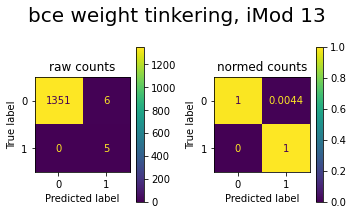

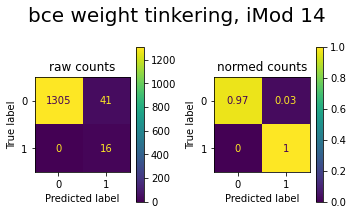

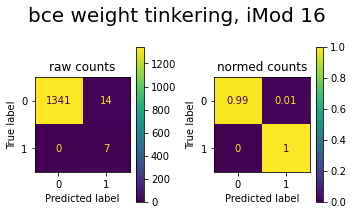

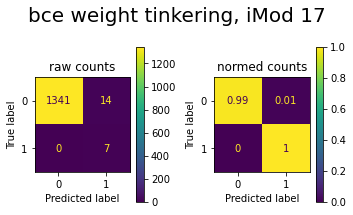

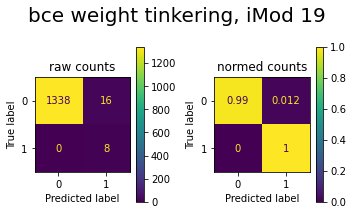

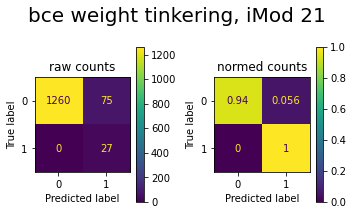

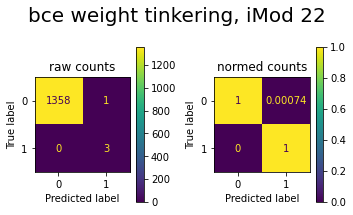

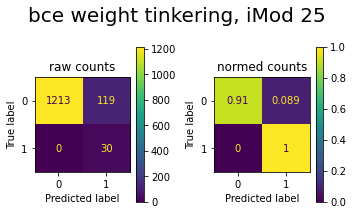

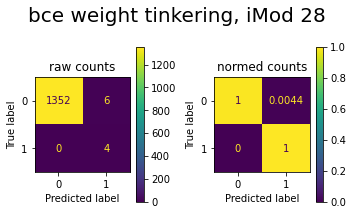

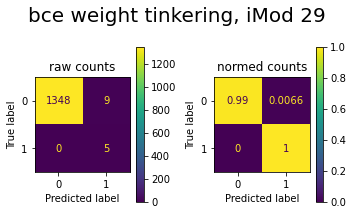

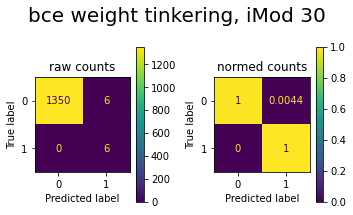

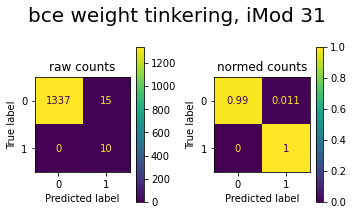

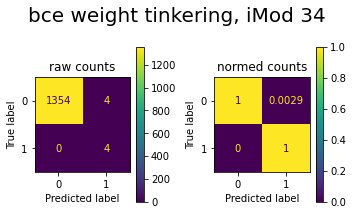

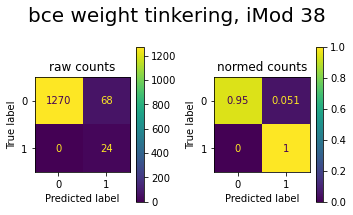

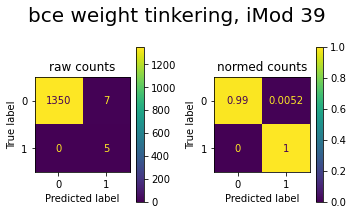

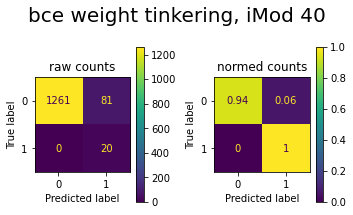

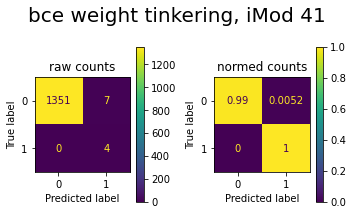

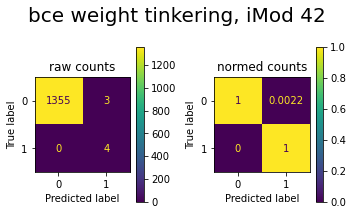

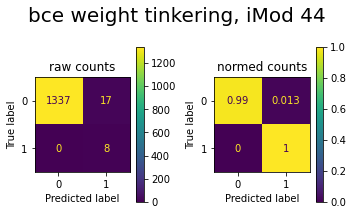

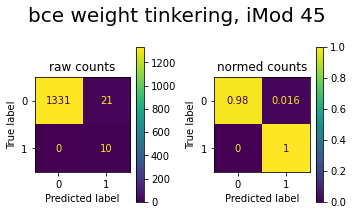

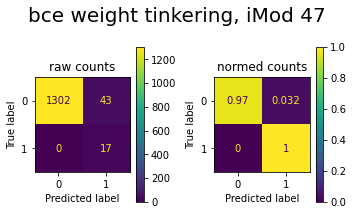

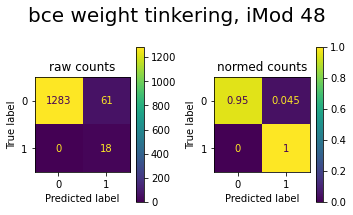

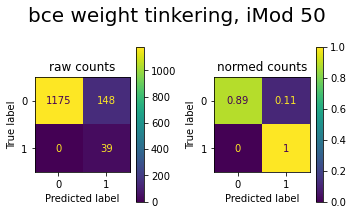

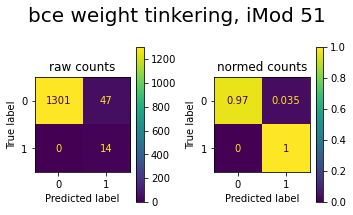

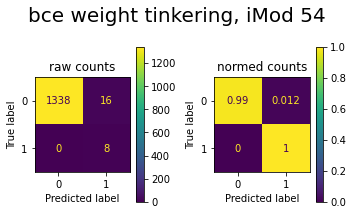

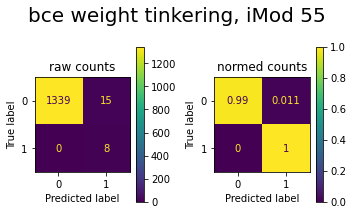

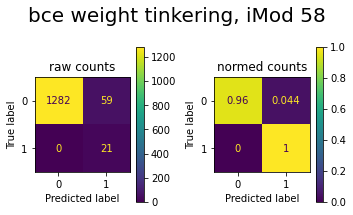

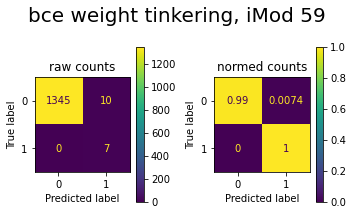

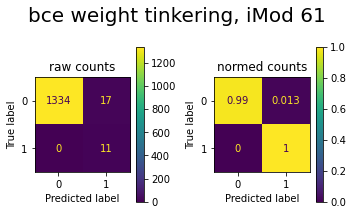

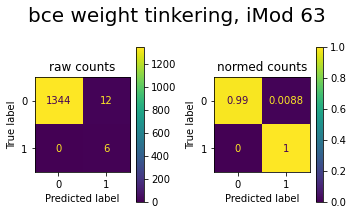

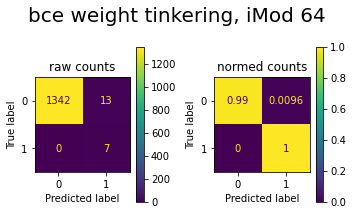

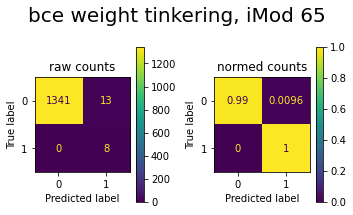

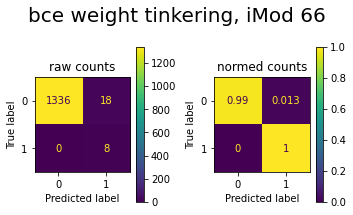

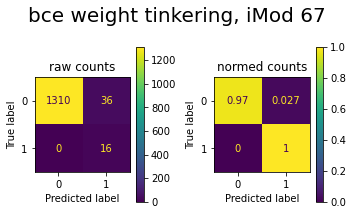

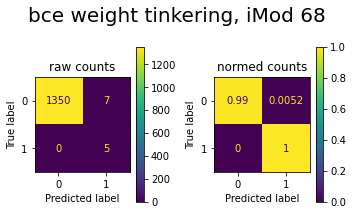

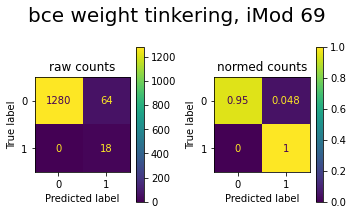

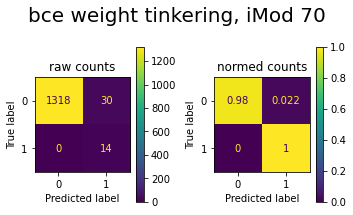

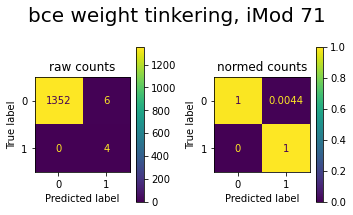

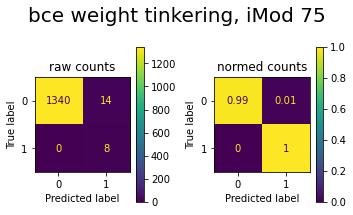

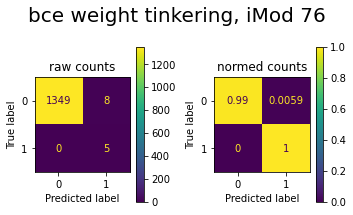

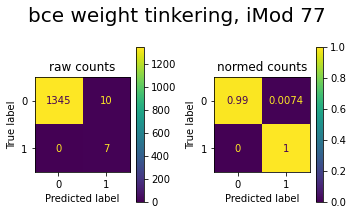

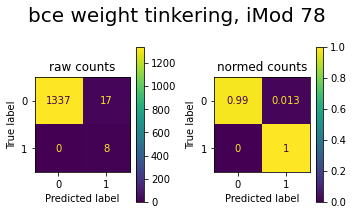

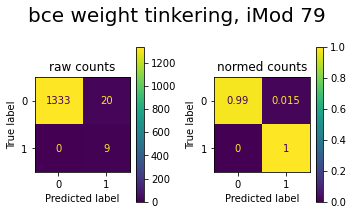

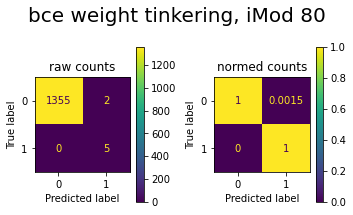

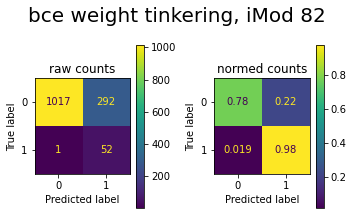

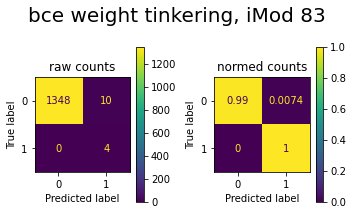

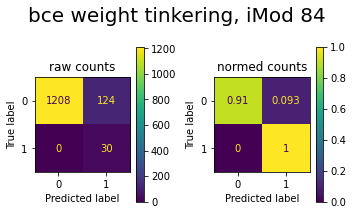

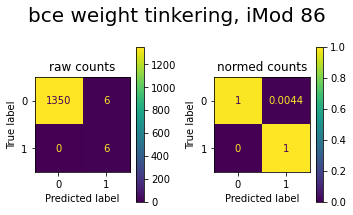

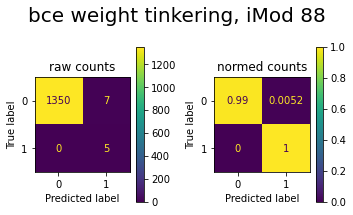

In [40]:
plot_confusion_multi([(net_strat_bcew_tink5,'bce weight tinkering')], Xtrain_strat,ytrain_strat,imods_filt)

In [41]:
#plot_confusion_multi([(net_strat_bcew_tink4,'bce weight tinkering')], Xval_strat,yval_strat,imods_filt)

In [42]:
#plot_confusion_multi([(net_strat_bcew_tink4,'bce weight tinkering')], Xtest_strat,ytest_strat,imods_filt)

In [43]:
net_strat_bcew_tink5.get_params()

{'module': models.DNA_2CNN_2FC_Multi,
 'criterion': BCEWithLogitsLoss(),
 'optimizer': torch.optim.adamw.AdamW,
 'lr': 0.0001,
 'max_epochs': 2000,
 'batch_size': 256,
 'iterator_train': torch.utils.data.dataloader.DataLoader,
 'iterator_valid': torch.utils.data.dataloader.DataLoader,
 'dataset': skorch.dataset.Dataset,
 'train_split': functools.partial(<function _make_split at 0x7f992046b0e0>, valid_ds=<skorch.dataset.Dataset object at 0x7f98c3a9e0d0>),
 'callbacks': [<skorch.callbacks.training.EarlyStopping at 0x7f985c3bd390>,
 'predict_nonlinearity': 'auto',
 'warm_start': False,
 'verbose': 1,
 'device': device(type='cuda'),
 '_kwargs': {'module__seq_len': 300,
  'module__n_tasks': 58,
  'module__num_filters1': 64,
  'module__num_filters2': 8,
  'module__kernel_size1': 8,
  'module__kernel_size2': 3,
  'module__conv_pool_size1': 3,
  'module__conv_pool_size2': 1,
  'module__fc_node_num1': 50,
  'module__fc_node_num2': 50,
  'module__dropout1': 0.2,
  'module__dropout2': 0.4,
  'opt

# SKORCH search

In [279]:
from sklearn.model_selection import RandomizedSearchCV


In [287]:
valid_ds = Dataset(Xval_strat, yval_strat)

net_search = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    #train_split=ValidSplit(0.2),
    #train_split=None,
    #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
    #train_split=k_fold,
    train_split=predefined_split(valid_ds),
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         #EarlyStopping(patience=100),
         EarlyStopping(patience=300),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)


In [288]:
params = {
    'lr': [0.001, 0.0005, 0.0001,],#loguniform(0.0001, 0.01)
    'batch_size':[32,64,128,256],
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer':[torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [291]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_squared_error', 
    #scoring=['precision','recall','f1_macro'], 
    scoring=['f1_macro'], 
    refit='f1_macro',
    n_jobs=-1, 
    #cv=3,#cv, 
    #cv=k_fold.split(Xtrain_strat,ytrain_strat),
    #cv=k_fold,
    random_state=7,
    verbose=1
)

In [292]:
search.fit(Xtrain_strat,ytrain_strat)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 116.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 209.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 323.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 473.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 638.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 649.9min finished


RandomizedSearchCV(estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__n_tasks=58,
  module__seq_len=300,
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'batch_size': [32, 64, 128, 256],
                                        'lr': [0.001, 0.0005, 0.0001],
                                        'module__conv_pool_size1': [2, 4],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__drop...
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                                                                 128],
                                        'module__num_filters2': [16, 32, 64,
                                

In [293]:
1+3

4

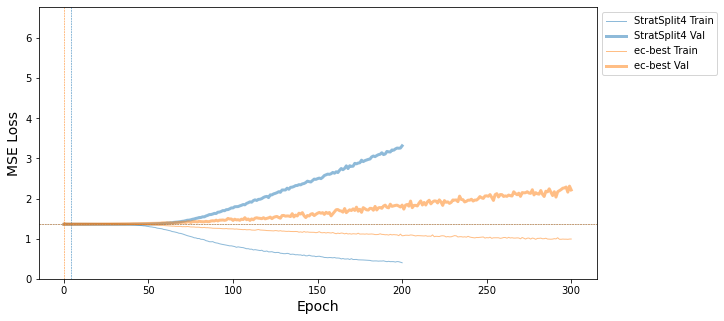

In [295]:
netss = [
    #(net_randsplit,"RandSplit"),
    (net_strat_bcew_tink4,"StratSplit4"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(netss)

### inspect hyperparam search results

In [296]:
search.best_estimator_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(16, 128, kernel_size=(1, 4), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=17792, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=58, bias=True)
    )
  ),
)

In [297]:
search.best_params_

{'optimizer': torch.optim.rmsprop.RMSprop,
 'module__num_filters2': 128,
 'module__num_filters1': 16,
 'module__kernel_size2': 4,
 'module__kernel_size1': 16,
 'module__fc_node_num2': 500,
 'module__fc_node_num1': 10,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 2,
 'lr': 0.0001,
 'batch_size': 256}

In [298]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       134.922935      6.769828         0.038413        0.005305   
1        32.628558      0.521362         0.016442        0.001764   
2        36.742397      0.480560         0.016439        0.002489   
3        47.250834      4.226117         0.017608        0.001342   
4        21.798534      1.560944         0.013442        0.000632   
..             ...           ...              ...             ...   
495      43.590408      1.275636         0.020677        0.001830   
496      40.046049      0.327979         0.019808        0.002273   
497      28.925875      5.456215         0.016243        0.001518   
498      61.296736      7.202483         0.021766        0.002760   
499      38.402370      5.537510         0.017794        0.005182   

                           param_optimizer param_module__num_filters2  \
0    <class 'torch.optim.rmsprop.RMSprop'>                        128   
1            <class 'torch.optim.sgd.SGD'>                         32   
2          <class 'torch.optim.adam.Adam'>                         64   
3        <class 'torch.optim.adamw.AdamW'>                         32   
4    <class 'torch.optim.rmsprop.RMSprop'>                         16   
..                                     ...                        ...   
495        <class 'torch.optim.adam.Adam'>                        128   
496        <class 'torch.optim.adam.Adam'>                         64   
497  <class 'torch.optim.rmsprop.RMSprop'>                        128   
498          <class 'torch.optim.sgd.SGD'>                         16   
499          <class 'torch.optim.sgd.SGD'>                         16   

    param_module__num_filters1 param_module__kernel_size2  \
0                           64                         16   
1                           16                         32   
2                           32                          4   
3                          128                         32   
4                           32                         32   
..                         ...                        ...   
495                         32                         32   
496                        128                          8   
497                         32                          4   
498                        128                          8   
499                        128                          8   

    param_module__kernel_size1 param_module__fc_node_num2  ...  \
0                            4                         10  ...   
1                            4                         50  ...   
2                           16                         10  ...   
3                            8                        100  ...   
4                            4                         10  ...   
..                         ...                        ...  ...   
495                          8                         50  ...   
496                         32                        100  ...   
497                         16                         50  ...   
498                          8                        500  ...   
499                          8                        500  ...   

                                                params split0_test_f1_macro  \
0    {'optimizer': <class 'torch.optim.rmsprop.RMSp...             0.003260   
1    {'optimizer': <class 'torch.optim.sgd.SGD'>, '...             0.003396   
2    {'optimizer': <class 'torch.optim.adam.Adam'>,...             0.004886   
3    {'optimizer': <class 'torch.optim.adamw.AdamW'...             0.002302   
4    {'optimizer': <class 'torch.optim.rmsprop.RMSp...             0.004010   
..                                                 ...                  ...   
495  {'optimizer': <class 'torch.optim.adam.Adam'>,...             0.016850   
496  {'optimizer': <class 'torch.optim.adam.Adam'>,...             0.012868   
497  {'optimizer': <class 'torch.optim.rmsprop.RMSp...        

In [300]:
sm_res_df = res_df[[
    "rank_test_f1_macro",
    "mean_test_f1_macro",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [301]:
sm_res_df

rank_test_f1_macro  mean_test_f1_macro param_module__num_filters1  \
0                   391            0.003754                         64   
1                   188            0.007440                         16   
2                   121            0.008560                         32   
3                   105            0.008809                        128   
4                    36            0.011006                         32   
..                  ...                 ...                        ...   
495                  96            0.008920                         32   
496                  20            0.011995                        128   
497                 229            0.006968                         32   
498                 282            0.005955                        128   
499                  87            0.009090                        128   

    param_module__num_filters2 param_module__kernel_size1  \
0                          128                          4   
1                           32                          4   
2                           64                         16   
3                           32                          8   
4                           16                          4   
..                         ...                        ...   
495                        128                          8   
496                         64                         32   
497                        128                         16   
498                         16                          8   
499                         16                          8   

    param_module__kernel_size2 param_lr param_module__fc_node_num1  \
0                           16   0.0005                        500   
1                           32   0.0001                        100   
2                            4    0.001                         10   
3                           32   0.0001                        100   
4                           32    0.001                         50   
..                         ...      ...                        ...   
495                         32   0.0005                         50   
496                          8   0.0001                         50   
497                          4    0.001                         10   
498                          8   0.0005                         10   
499                          8   0.0001                        500   

    param_module__fc_node_num2 opt_name  
0                           10  RMSprop  
1                           50      SGD  
2                           10     Adam  
3                          100    AdamW  
4                           10  RMSprop  
..                         ...      ...  
495                         50     Adam  
496                        100     Adam  
497                         50  RMSprop  
498                        500      SGD  
499                        500      SGD  

[500 rows x 10 columns]

In [303]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_f1_macro:Q',
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [305]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_f1_macro:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [306]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [307]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [308]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [310]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [311]:
res_df.to_csv('ec_iMod_out/hyper_clf_weightedLoss.tsv',sep='\t',index=False)

In [313]:
# best estimator predictions
cls_full_train_df = view_cls_report(search.best_estimator_,Xtrain_strat,ytrain_strat,imods_filt)
cls_full_val_df = view_cls_report(search.best_estimator_,Xval_strat,yval_strat,imods_filt)
cls_full_test_df = view_cls_report(search.best_estimator_,Xtest_strat,ytest_strat,imods_filt)


alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

Running searchbest train


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


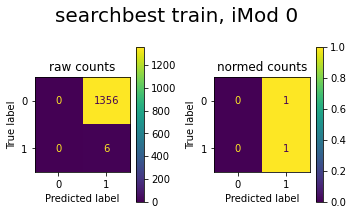

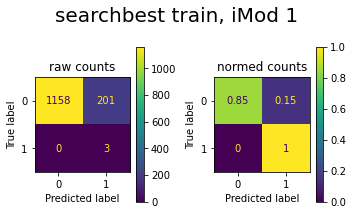

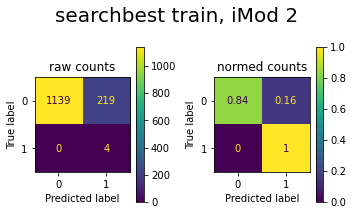

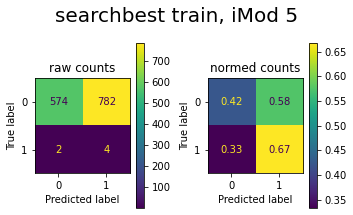

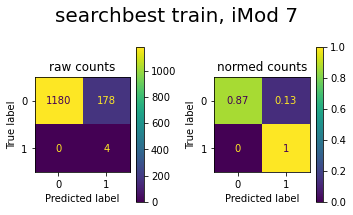

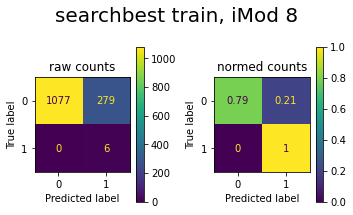

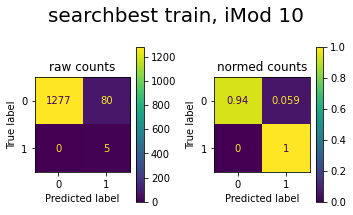

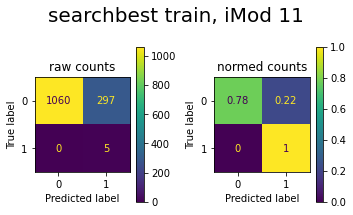

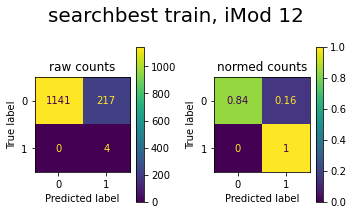

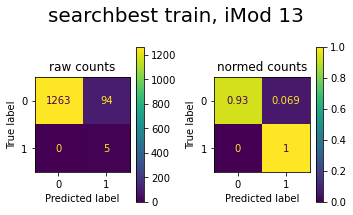

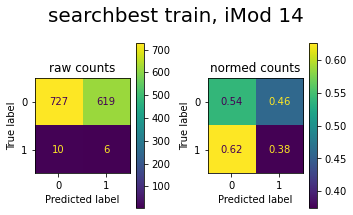

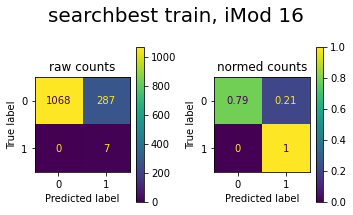

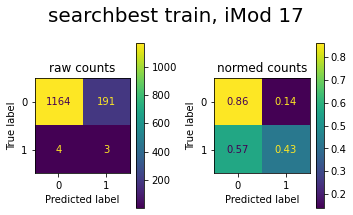

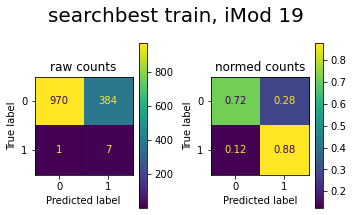

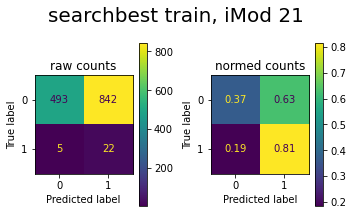

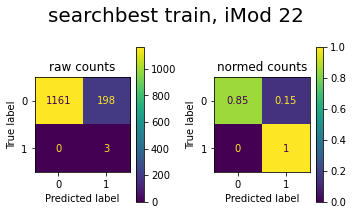

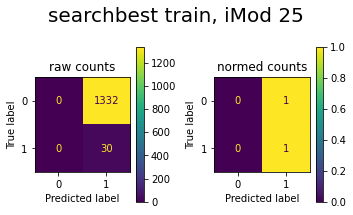

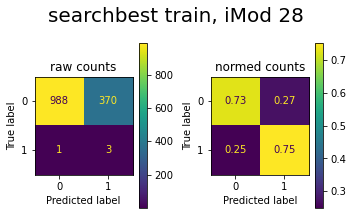

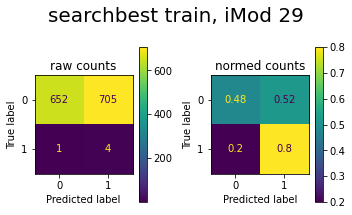

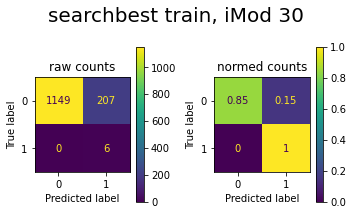

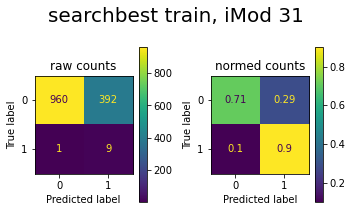

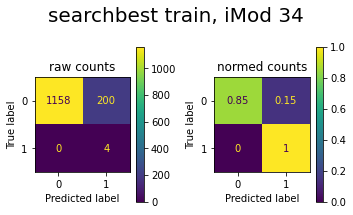

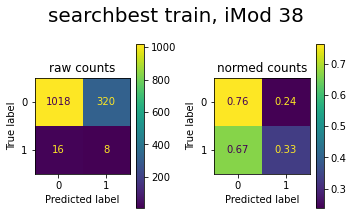

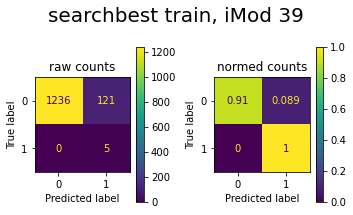

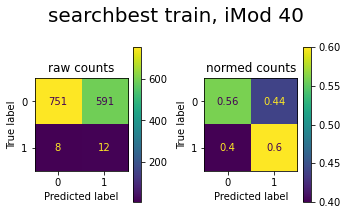

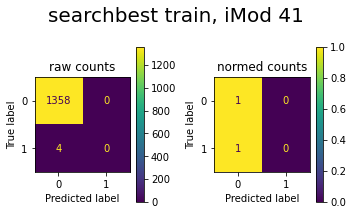

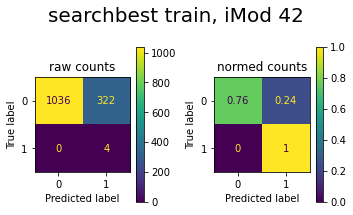

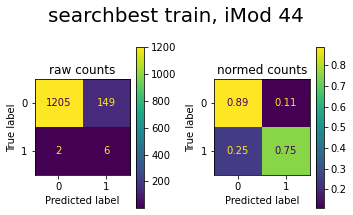

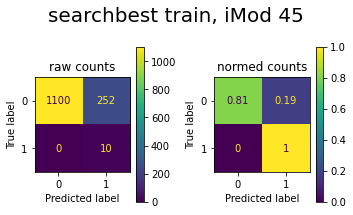

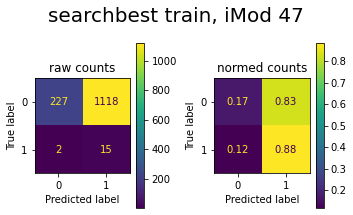

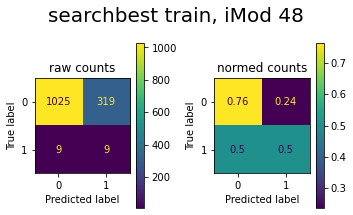

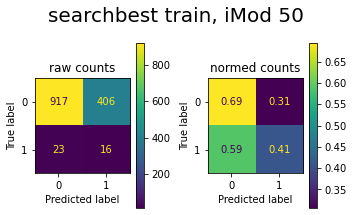

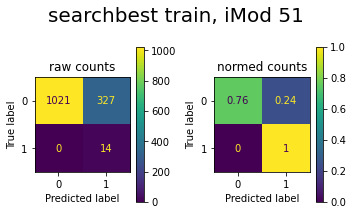

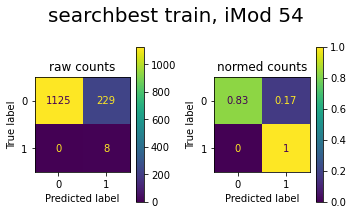

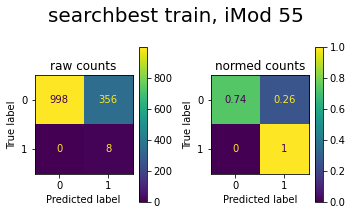

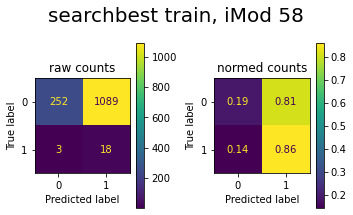

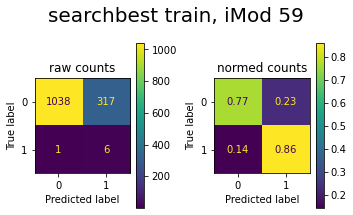

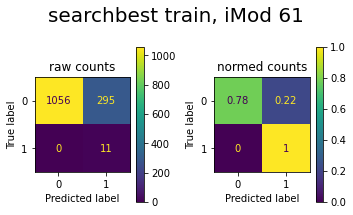

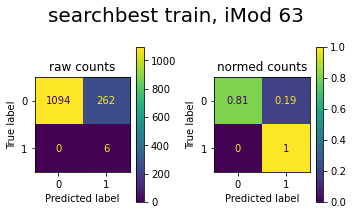

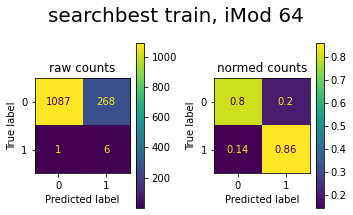

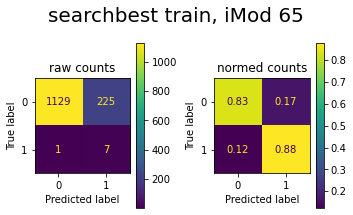

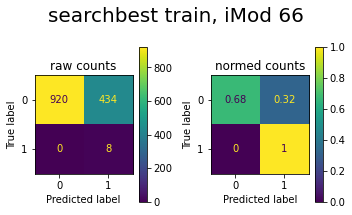

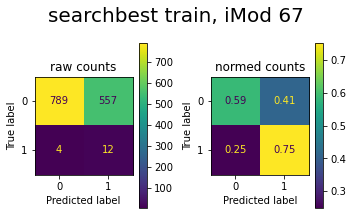

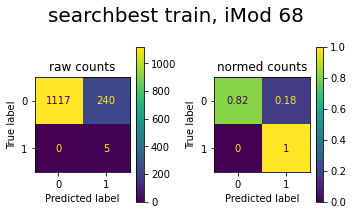

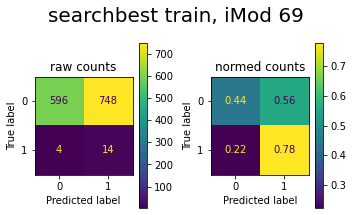

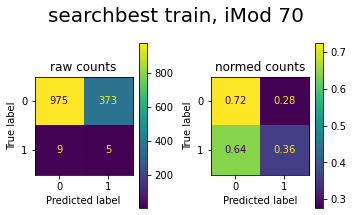

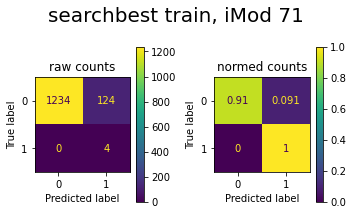

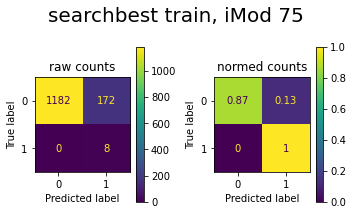

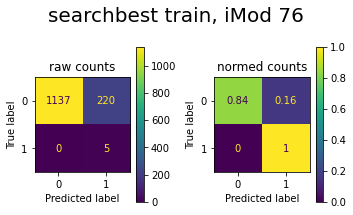

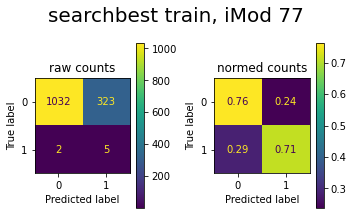

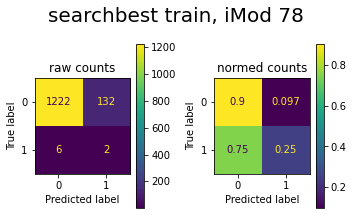

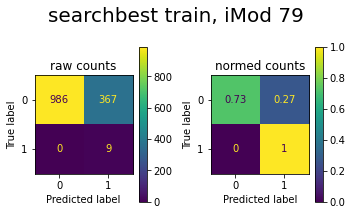

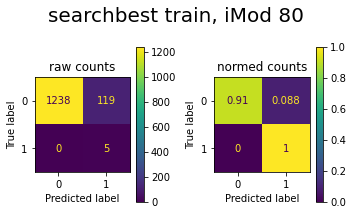

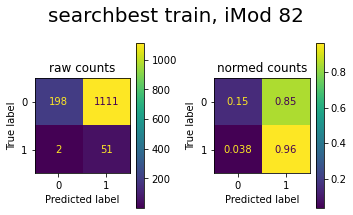

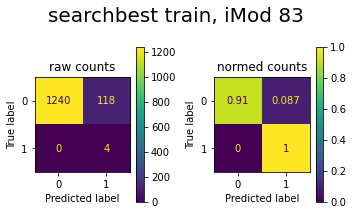

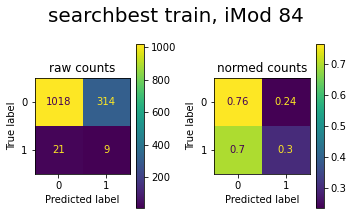

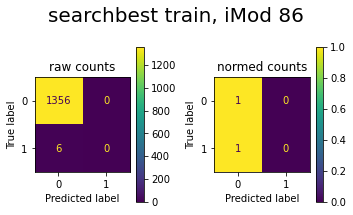

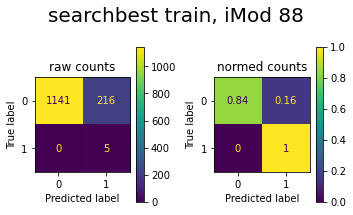

In [314]:
plot_confusion_multi([(search.best_estimator_,'searchbest train')], Xtrain_strat,ytrain_strat,imods_filt)

Running searchbest val


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


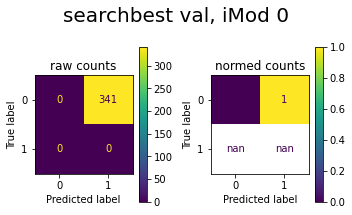

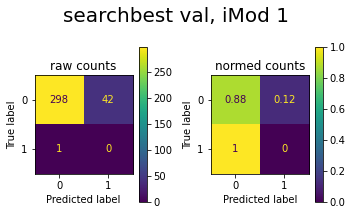

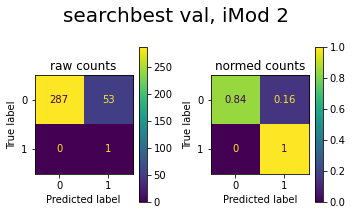

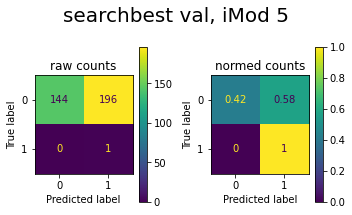

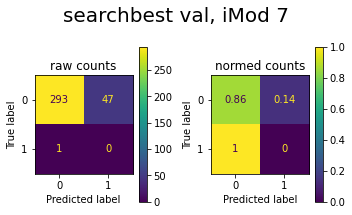

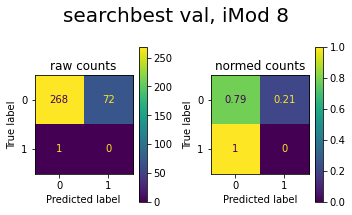

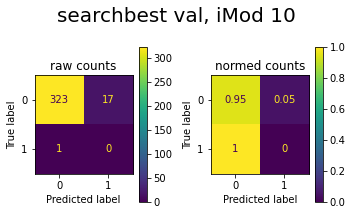

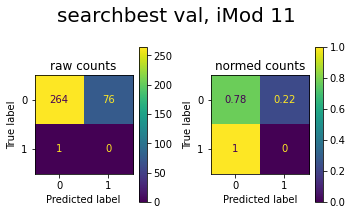

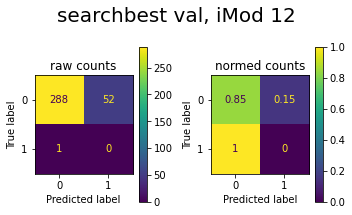

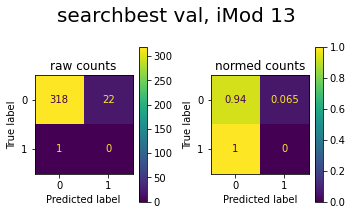

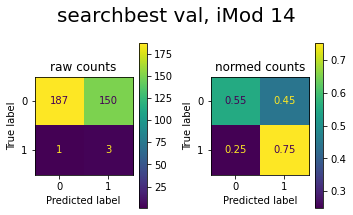

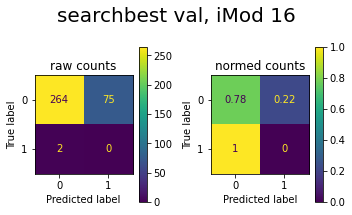

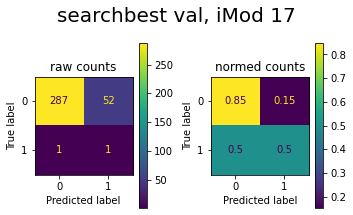

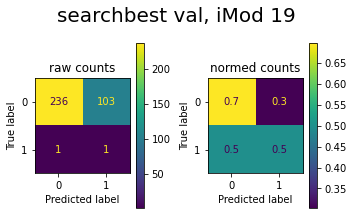

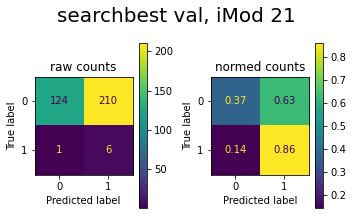

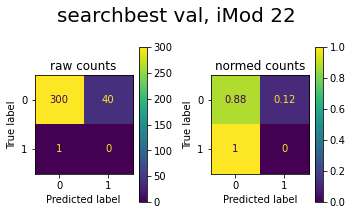

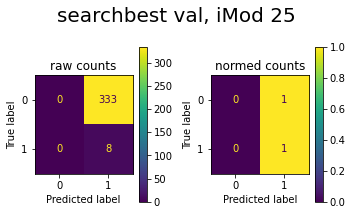

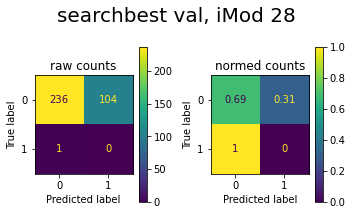

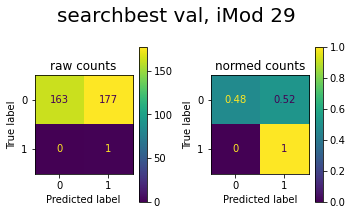

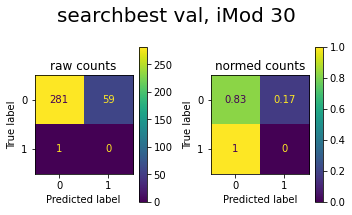

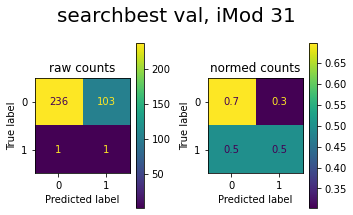

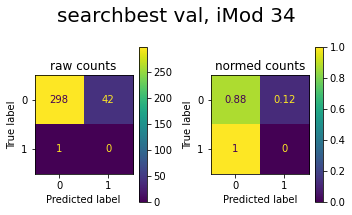

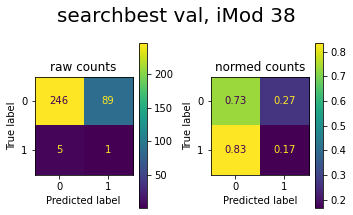

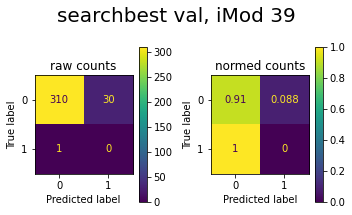

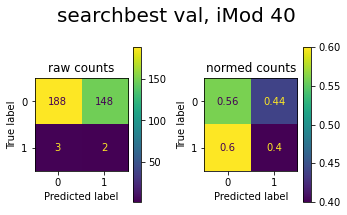

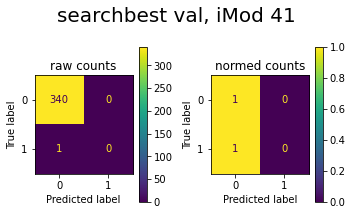

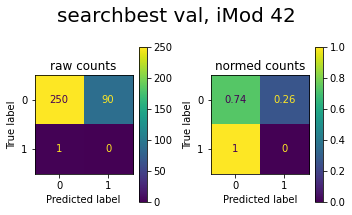

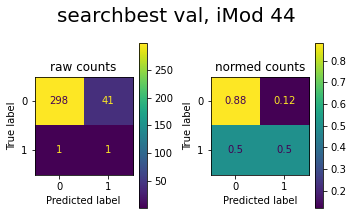

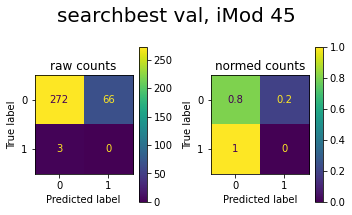

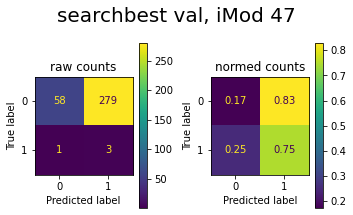

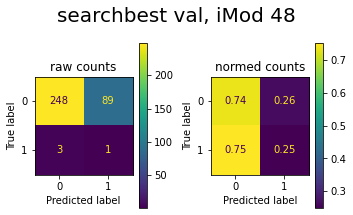

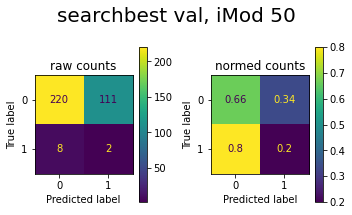

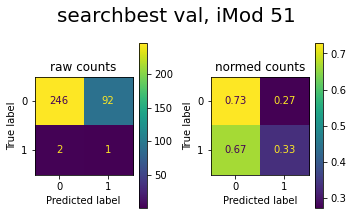

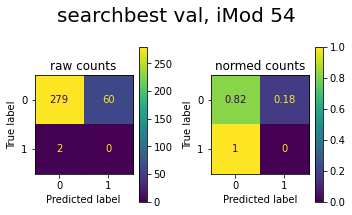

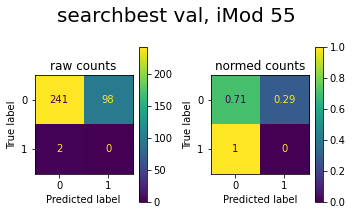

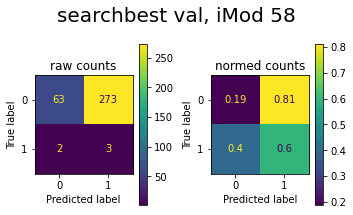

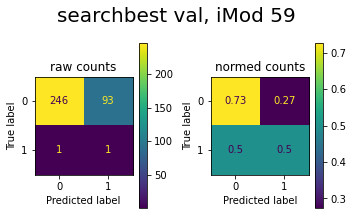

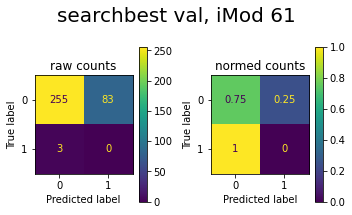

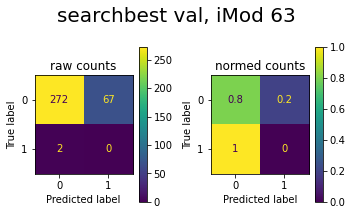

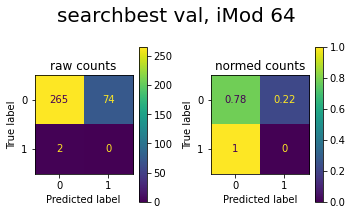

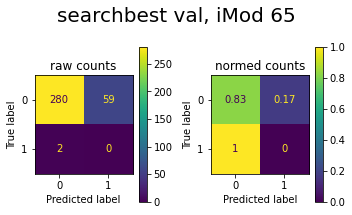

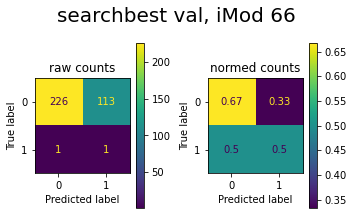

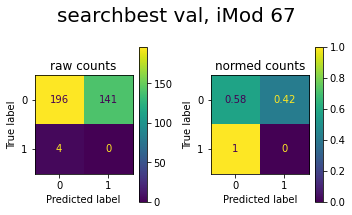

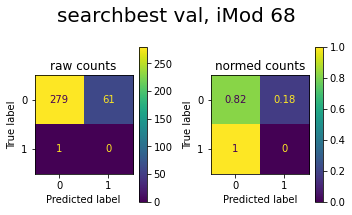

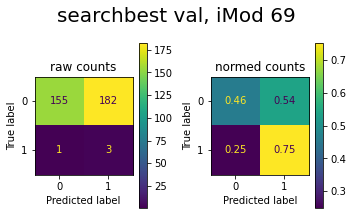

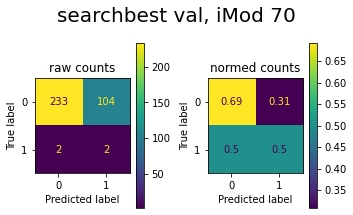

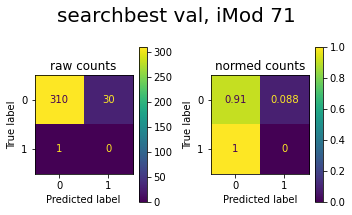

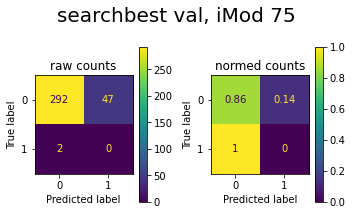

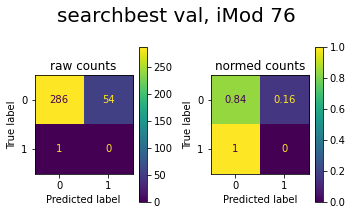

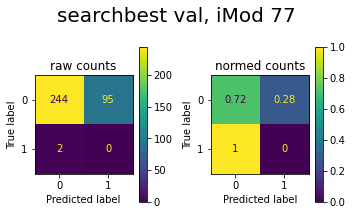

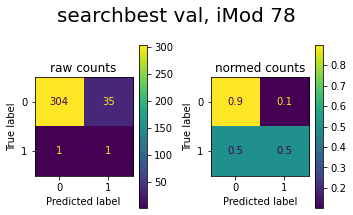

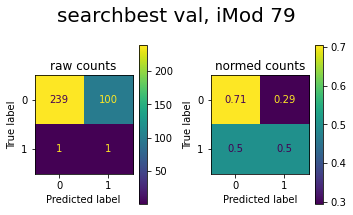

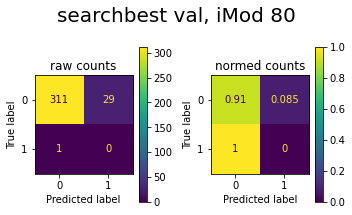

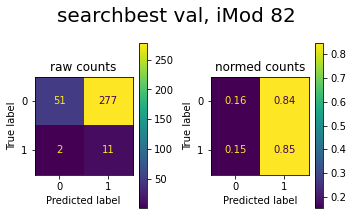

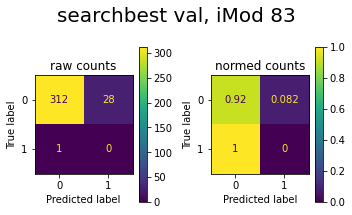

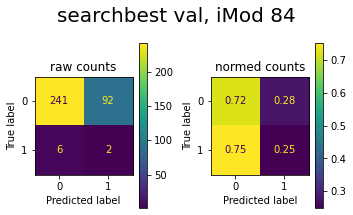

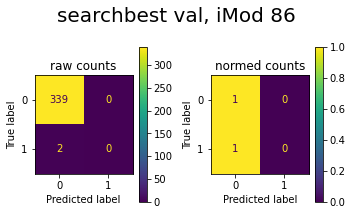

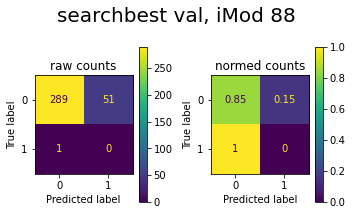

In [315]:
plot_confusion_multi([(search.best_estimator_,'searchbest val')], Xval_strat,yval_strat,imods_filt)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [74]:
net_cvp = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        #train_split=ValidSplit(0.2),
        #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
        train_split=None,
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
        module__dropout1 = 0.2,
        module__dropout2 = 0.2,
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=200,monitor='train_loss'),
             # suggested monitoring train loss when i want to do gridsearchcv with early stop?
             # https://github.com/skorch-dev/skorch/issues/837
             #Checkpoint(load_best=True),
             GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None,
        verbose=1
    )

In [75]:
from sklearn.model_selection import cross_val_predict

In [76]:
y_pred = cross_val_predict(net_cvp, Xtrain_strat, ytrain_strat, cv=5)

# these instructions for using skorch with cross_val_predict don't work
# https://skorch.readthedocs.io/en/latest/user/dataset.html?highlight=fold#validsplit

# when train_split=None, then "valid loss" is not in history
# when train_split is left default, it says StratifiedCV needs a suitable y

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5955  0.0902
      2        0.1069  0.0893
      3        0.0700  0.0672
      4        0.0555  0.0666
      5        0.0519  0.0659
      6        0.0500  0.0603
      7        0.0489  0.0582
      8        0.0483  0.0583
      9        0.0483  0.0579
     10        0.0482  0.0589
     11        0.0484  0.0579
     12        0.0480  0.0546
     13        0.0482  0.0576
     14        0.0481  0.0568
     15        0.0482  0.0570
     16        0.0481  0.0566
     17        0.0478  0.0570
     18        0.0479  0.0573
     19        0.0480  0.0577
     20        0.0482  0.0584
     21        0.0480  0.0583
     22        0.0474  0.0579
     23        0.0474  0.0584
     24        0.0475  0.0580
     25        0.0473  0.0587
     26        0.0475  0.0579
     27        0.0471  0.0580
     28        0.0468  0.0579
     29        0.0467  0.0580
     30        0.0475  0.0579
     31        0.0467  0.0579
     32   

    241        0.0040  0.0555
    242        0.0042  0.0554
    243        0.0048  0.0555
    244        0.0046  0.0555
    245        0.0056  0.0559
    246        0.0044  0.0558
    247        0.0041  0.0557
    248        0.0039  0.0556
    249        0.0042  0.0562
    250        0.0039  0.0563
    251        0.0050  0.0559
    252        0.0035  0.0559
    253        0.0051  0.0562
    254        0.0055  0.0564
    255        0.0051  0.0559
    256        0.0049  0.0558
    257        0.0048  0.0556
    258        0.0043  0.0556
    259        0.0032  0.0557
    260        0.0041  0.0557
    261        0.0041  0.0561
    262        0.0053  0.0556
    263        0.0037  0.0556
    264        0.0036  0.0555
    265        0.0048  0.0558
    266        0.0035  0.0559
    267        0.0043  0.0559
    268        0.0038  0.0556
    269        0.0039  0.0556
    270        0.0046  0.0557
    271        0.0048  0.0559
    272        0.0034  0.0561
    273        0.0041  0.0560
    274   

    512        0.0060  0.0582
    513        0.0043  0.0582
    514        0.0047  0.0585
    515        0.0046  0.0586
    516        0.0044  0.0578
    517        0.0053  0.0577
    518        0.0054  0.0579
    519        0.0048  0.0578
    520        0.0041  0.0576
    521        0.0032  0.0577
    522        0.0041  0.0578
    523        0.0040  0.0577
    524        0.0043  0.0577
    525        0.0036  0.0575
    526        0.0025  0.0576
    527        0.0043  0.0575
    528        0.0034  0.0576
    529        0.0039  0.0573
    530        0.0046  0.0574
    531        0.0039  0.0578
    532        0.0045  0.0575
    533        0.0029  0.0576
    534        0.0039  0.0578
    535        0.0039  0.0578
    536        0.0041  0.0576
    537        0.0043  0.0579
    538        0.0040  0.0577
    539        0.0043  0.0580
    540        0.0049  0.0576
    541        0.0033  0.0578
    542        0.0047  0.0575
    543        0.0041  0.0576
    544        0.0037  0.0579
    545   

      2        0.1280  0.0578
      3        0.0697  0.0594
      4        0.0581  0.0584
      5        0.0525  0.0580
      6        0.0507  0.0581
      7        0.0489  0.0585
      8        0.0486  0.0586
      9        0.0484  0.0581
     10        0.0486  0.0574
     11        0.0481  0.0575
     12        0.0482  0.0577
     13        0.0481  0.0576
     14        0.0482  0.0573
     15        0.0485  0.0574
     16        0.0485  0.0574
     17        0.0478  0.0576
     18        0.0482  0.0569
     19        0.0481  0.0574
     20        0.0480  0.0579
     21        0.0478  0.0576
     22        0.0475  0.0566
     23        0.0476  0.0555
     24        0.0475  0.0558
     25        0.0473  0.0559
     26        0.0474  0.0559
     27        0.0473  0.0555
     28        0.0472  0.0555
     29        0.0471  0.0557
     30        0.0468  0.0565
     31        0.0470  0.0551
     32        0.0469  0.0552
     33        0.0466  0.0551
     34        0.0467  0.0555
     35   

    242        0.0029  0.0555
    243        0.0029  0.0556
    244        0.0027  0.0556
    245        0.0029  0.0557
    246        0.0034  0.0575
    247        0.0027  0.0585
    248        0.0036  0.0589
    249        0.0029  0.0586
    250        0.0045  0.0586
    251        0.0036  0.0584
    252        0.0033  0.0584
    253        0.0038  0.0585
    254        0.0037  0.0588
    255        0.0043  0.0583
    256        0.0034  0.0582
    257        0.0040  0.0584
    258        0.0032  0.0585
    259        0.0036  0.0592
    260        0.0036  0.0593
    261        0.0031  0.0587
    262        0.0031  0.0586
    263        0.0027  0.0583
    264        0.0032  0.0579
    265        0.0025  0.0589
    266        0.0033  0.0585
    267        0.0037  0.0584
    268        0.0032  0.0582
    269        0.0038  0.0585
    270        0.0032  0.0580
    271        0.0047  0.0579
    272        0.0038  0.0571
    273        0.0037  0.0571
    274        0.0026  0.0579
    275   

    514        0.0042  0.0586
    515        0.0042  0.0590
    516        0.0031  0.0592
    517        0.0031  0.0587
    518        0.0047  0.0586
    519        0.0042  0.0583
    520        0.0038  0.0592
    521        0.0042  0.0591
    522        0.0033  0.0586
    523        0.0045  0.0587
    524        0.0041  0.0585
    525        0.0047  0.0587
    526        0.0037  0.0594
    527        0.0053  0.0584
    528        0.0041  0.0586
    529        0.0057  0.0587
    530        0.0039  0.0585
    531        0.0032  0.0586
    532        0.0023  0.0586
    533        0.0026  0.0587
    534        0.0026  0.0583
    535        0.0034  0.0589
    536        0.0038  0.0586
    537        0.0031  0.0590
    538        0.0040  0.0587
    539        0.0038  0.0584
    540        0.0027  0.0589
    541        0.0038  0.0585
    542        0.0063  0.0586
    543        0.0039  0.0587
    544        0.0051  0.0585
    545        0.0041  0.0582
    546        0.0045  0.0584
    547   

     89        0.0056  0.0551
     90        0.0052  0.0551
     91        0.0049  0.0548
     92        0.0048  0.0550
     93        0.0050  0.0545
     94        0.0044  0.0563
     95        0.0047  0.0550
     96        0.0043  0.0551
     97        0.0035  0.0552
     98        0.0034  0.0552
     99        0.0031  0.0551
    100        0.0030  0.0551
    101        0.0037  0.0552
    102        0.0028  0.0551
    103        0.0031  0.0551
    104        0.0028  0.0552
    105        0.0029  0.0551
    106        0.0033  0.0549
    107        0.0039  0.0550
    108        0.0035  0.0552
    109        0.0042  0.0556
    110        0.0036  0.0553
    111        0.0048  0.0552
    112        0.0035  0.0551
    113        0.0039  0.0551
    114        0.0031  0.0551
    115        0.0031  0.0551
    116        0.0037  0.0552
    117        0.0030  0.0546
    118        0.0026  0.0575
    119        0.0036  0.0574
    120        0.0031  0.0564
    121        0.0031  0.0561
    122   

    357        0.0020  0.0571
    358        0.0035  0.0572
    359        0.0029  0.0571
    360        0.0024  0.0572
    361        0.0021  0.0584
    362        0.0020  0.0577
    363        0.0022  0.0575
    364        0.0028  0.0577
    365        0.0036  0.0577
    366        0.0032  0.0560
    367        0.0043  0.0559
    368        0.0022  0.0560
    369        0.0033  0.0563
    370        0.0038  0.0560
    371        0.0020  0.0558
    372        0.0036  0.0557
    373        0.0049  0.0556
    374        0.0041  0.0558
    375        0.0044  0.0561
    376        0.0064  0.0560
    377        0.0059  0.0559
    378        0.0059  0.0560
    379        0.0042  0.0561
    380        0.0051  0.0558
    381        0.0052  0.0560
    382        0.0042  0.0554
    383        0.0030  0.0555
    384        0.0035  0.0554
    385        0.0041  0.0564
    386        0.0036  0.0562
    387        0.0028  0.0562
    388        0.0035  0.0559
    389        0.0036  0.0559
    390   

    190        0.0028  0.0550
    191        0.0032  0.0549
    192        0.0040  0.0550
    193        0.0034  0.0549
    194        0.0035  0.0549
    195        0.0041  0.0547
    196        0.0037  0.0547
    197        0.0040  0.0549
    198        0.0045  0.0548
    199        0.0045  0.0548
    200        0.0046  0.0549
    201        0.0044  0.0547
    202        0.0046  0.0546
    203        0.0043  0.0546
    204        0.0040  0.0547
    205        0.0040  0.0547
    206        0.0052  0.0549
    207        0.0050  0.0546
    208        0.0041  0.0548
    209        0.0034  0.0548
    210        0.0032  0.0550
    211        0.0031  0.0552
    212        0.0037  0.0550
    213        0.0037  0.0550
    214        0.0037  0.0550
    215        0.0032  0.0549
    216        0.0038  0.0550
    217        0.0042  0.0550
    218        0.0036  0.0549
    219        0.0032  0.0549
    220        0.0030  0.0548
    221        0.0039  0.0547
    222        0.0038  0.0550
    223   

    461        0.0025  0.0549
    462        0.0020  0.0549
    463        0.0019  0.0547
    464        0.0024  0.0548
    465        0.0017  0.0552
    466        0.0022  0.0554
    467        0.0028  0.0553
    468        0.0037  0.0551
    469        0.0029  0.0551
    470        0.0032  0.0550
    471        0.0034  0.0550
    472        0.0052  0.0550
    473        0.0050  0.0551
    474        0.0030  0.0551
    475        0.0040  0.0551
    476        0.0043  0.0550
    477        0.0029  0.0550
    478        0.0028  0.0549
    479        0.0032  0.0546
    480        0.0035  0.0548
    481        0.0042  0.0548
    482        0.0025  0.0549
    483        0.0037  0.0550
    484        0.0036  0.0550
    485        0.0038  0.0550
    486        0.0040  0.0548
    487        0.0035  0.0550
    488        0.0036  0.0550
    489        0.0021  0.0553
    490        0.0033  0.0552
    491        0.0029  0.0550
    492        0.0029  0.0551
    493        0.0032  0.0553
    494   

    187        0.0349  0.0550
    188        0.0349  0.0550
    189        0.0349  0.0551
    190        0.0349  0.0550
    191        0.0351  0.0551
    192        0.0349  0.0551
    193        0.0351  0.0552
    194        0.0350  0.0551
    195        0.0350  0.0549
    196        0.0350  0.0550
    197        0.0349  0.0556
    198        0.0348  0.0554
    199        0.0350  0.0557
    200        0.0350  0.0553
    201        0.0349  0.0550
    202        0.0349  0.0550
    203        0.0349  0.0549
    204        0.0349  0.0548
    205        0.0349  0.0549
    206        0.0349  0.0550
    207        0.0350  0.0549
    208        0.0349  0.0547
    209        0.0349  0.0551
    210        0.0349  0.0550
    211        0.0349  0.0552
    212        0.0348  0.0551
    213        0.0348  0.0549
    214        0.0349  0.0550
    215        0.0348  0.0548
    216        0.0349  0.0548
    217        0.0349  0.0548
Stopping since train_loss has not improved in the last 200 epochs.


In [77]:
netts = [
    #(search.best_estimator_,'ec-best_oldarch'),
    (net_cvp, 'manual cvp?')
]

sk_loss_plot(netts)

# errors because cross_val_predict doesn't actually train the model...?

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>

In [78]:
net_cvp

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__conv_pool_size1=3,
  module__conv_pool_size2=1,
  module__dropout1=0.2,
  module__dropout2=0.2,
  module__fc_node_num1=100,
  module__fc_node_num2=100,
  module__kernel_size1=8,
  module__kernel_size2=8,
  module__n_tasks=58,
  module__num_filters1=128,
  module__num_filters2=64,
  module__seq_len=300,
)

In [79]:
y_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [80]:
def view_cls_report2(yt,yp,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the classification report
    cls_rep = classification_report(yt, yp,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df

In [81]:
# from cross_val_predict preds
view_cls_report2(ytrain_strat,y_pred,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

imod  precision  recall  f1-score  support
0      0        0.0     0.0       0.0        6
1      1        0.0     0.0       0.0        3
2      2        0.0     0.0       0.0        4
3      5        0.0     0.0       0.0        6
4      7        0.0     0.0       0.0        4
5      8        0.0     0.0       0.0        6
6     10        0.0     0.0       0.0        5
7     11        0.0     0.0       0.0        5
8     12        0.0     0.0       0.0        4
9     13        0.0     0.0       0.0        5
10    14        0.0     0.0       0.0       16
11    16        0.0     0.0       0.0        7
12    17        0.0     0.0       0.0        7
13    19        0.0     0.0       0.0        8
14    21        0.0     0.0       0.0       27
15    22        0.0     0.0       0.0        3
16    25        0.0     0.0       0.0       30
17    28        0.0     0.0       0.0        4
18    29        0.0     0.0       0.0        5
19    30        0.0     0.0       0.0        6
20    31        0.0     0.0       0.0       10
21    34        0.0     0.0       0.0        4
22    38        0.0     0.0       0.0       24
23    39        0.0     0.0       0.0        5
24    40        0.0     0.0       0.0       20
25    41        0.0     0.0       0.0        4
26    42        0.0     0.0       0.0        4
27    44        0.0     0.0       0.0        8
28    45        0.0     0.0       0.0       10
29    47        0.0     0.0       0.0       17
30    48        0.0     0.0       0.0       18
31    50        0.0     0.0       0.0       39
32    51        0.0     0.0       0.0       14
33    54        0.0     0.0       0.0        8
34    55        0.0     0.0       0.0        8
35    58        0.0     0.0       0.0       21
36    59        0.0     0.0       0.0        7
37    61        0.0     0.0       0.0       11
38    63        0.0     0.0       0.0        6
39    64        0.0     0.0       0.0        7
40    65        0.0     0.0       0.0        8
41    66        0.0     0.0       0.0        8
42    67        0.0     0.0       0.0       16
43    68        0.0     0.0       0.0        5
44    69        0.0     0.0       0.0       18
45    70        0.0     0.0       0.0       14
46    71        0.0     0.0       0.0        4
47    75        0.0     0.0       0.0        8
48    76        0.0     0.0       0.0        5
49    77        0.0     0.0       0.0        7
50    78        0.0     0.0       0.0        8
51    79        0.0     0.0       0.0        9
52    80        0.0     0.0       0.0        5
53    82        0.0     0.0       0.0       53
54    83        0.0     0.0       0.0        4
55    84        0.0     0.0       0.0       30
56    86        0.0     0.0       0.0        6
57    88        0.0     0.0       0.0        5

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


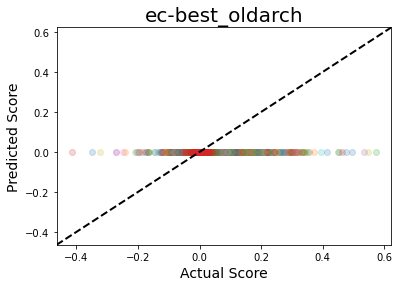

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

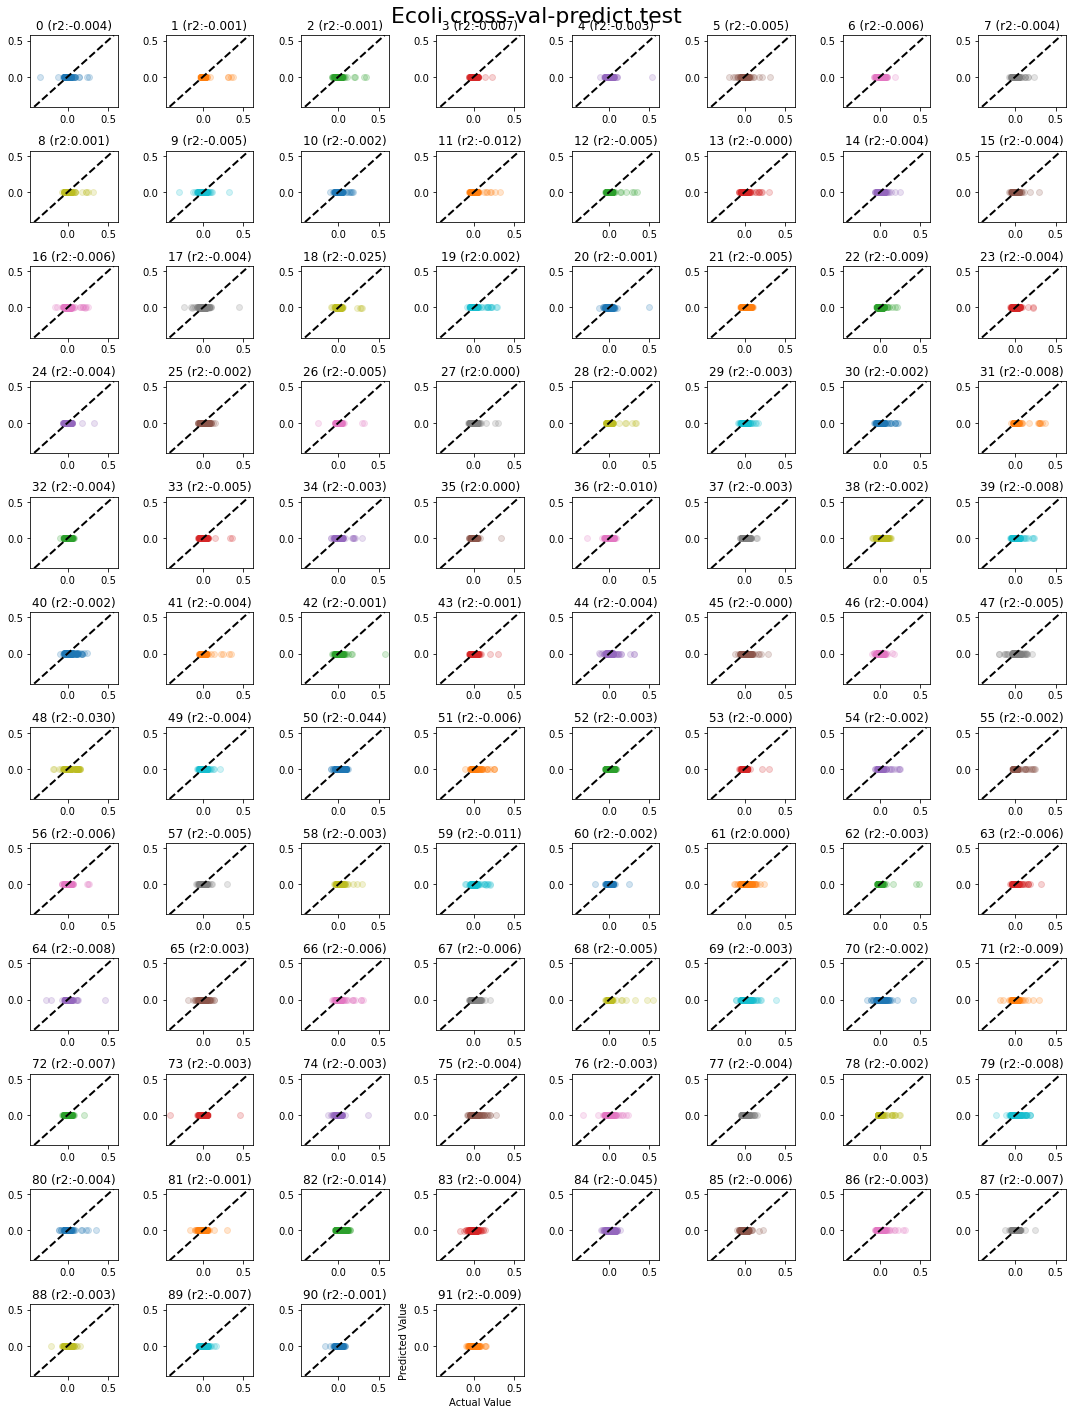

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one